The graphics in this RISE slideshow may not fit to certain screens or resolutions.  

### Overview

In this kernel, we compare assorted regression and network models by their ability to forecast electric motor rotor temperature and torque.  

The dataset contains 52 separate trials with unique driving schemes.  We will focus on trials that appear to simulate highway driving. This will be identified by gradual changes in motor speed and torque.  

We will begin by examining the time series progression of each feature, allowing us to select trials that represent highway driving.  

Starting with an Ordinary Least Squares regression, we compare it to the regularization models Ridge (L2) Regression, Lasso (L1) Regression, and ElasticNet Regression.  We will also examine a Random Forest model.

We then use Keras and TensorFlow implement a Long Short Term Memory Recurrent Neural Network.  This takes into account recent sensor readings instead of just current readings.  

By the end of the analysis, we should have a process for predicting rotor temperature and torque. 

## Context

The dataset aggregates sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University. This dataset is mildly anonymized.

All recordings are sampled at 2 Hz (once every half second). The dataset consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id". A measurement session can last between one and six hours long, between 7200 and 43200 samples.

The motor is excited by hand-designed driving cycles denoting a reference motor speed and a reference torque. Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque. Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

The most interesting target features are rotor temperature ("pm"), stator temperatures ("stator_") and torque. Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle.

Being able to have strong estimators for the rotor temperature helps the automotive industry to manufacture motors with less material and enables control strategies to utilize the motor to its maximum capability. A precise torque estimate leads to more accurate and adequate control of the motor, reducing power losses and eventually heat build-up.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # TensorFlow throws FutureWarning

import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import tensorflow as tf
import keras
import statsmodels.api as sm
import time
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.metrics import r2_score

sns.set(style='white', palette='muted', color_codes=True)  #This style is a bit easier to read.

Using TensorFlow backend.


## Explorational Analysis

To start we investigate the columns and summarize their context.  

In [2]:
raw_df = pd.read_csv('Dataset zips/electric-motor-temperature/pmsm_temperature_data.csv')
df = raw_df.copy()

In [3]:
list(df.keys())

['ambient',
 'coolant',
 'u_d',
 'u_q',
 'motor_speed',
 'torque',
 'i_d',
 'i_q',
 'pm',
 'stator_yoke',
 'stator_tooth',
 'stator_winding',
 'profile_id']

**profile_id**: the id of the session

**u_q**: Voltage q-component.  The quadrature or out of phase voltage. 

**u_d**: Voltage d-component.  The in phase voltage.

**i_q**: Current q-component, quadrature or out of phase current.

**i_d**: Current d-component, in phase current.

**motor speed**: the rotational speed of the stator.

**torque**:  induced by current.

**ambient**: Temperature as measured by a thermal sensor located closely to the stator.

**coolant**: temperature of water. The motor is water cooled. Measurement is taken at outflow.

**pm**: Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared sensor

**stator_yoke**: the center cylinder of the stator, temperature measured with a thermal sensor.

**stator_tooth**: the protrusions where the wire is wound, temperature measured with a thermal sensor.

**stator_winding**: the wires wound to make an electro magnet, temperature measured with a thermal sensor.

There are multiple sessions, denoted by profile_id.  We will begin by exploring this axis of the data.  

In [4]:
df['profile_id'].unique()

array([ 4,  6, 10, 11, 20, 27, 29, 30, 31, 32, 36, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       72], dtype=int64)

We may change the index later so at this time we will record each sample's id.

In [5]:
df['sample_id'] = list(df.index)

We can create a dataframe that records the size of each trial, df_trials.

In [6]:
id_counts = df['profile_id'].value_counts()
trial_col = ['profile_id', 'first_id', 'last_id']
trials = []
for ids in list(id_counts.index):
    trials.append([ids, df[df['profile_id'] == ids].index.min(), df[df['profile_id'] == ids].index.max()])
df_trials = pd.DataFrame(trials, columns=trial_col)
df_trials['samples'] = df_trials['last_id'] - df_trials['first_id'] + 1 # Add a field for total number of samples
df_trials['runtime_min'] = (df_trials['samples'] / 2) / 60 # Length of trial in minutes


In [7]:
df_trials.sort_values('first_id').head(10)

profile_id  first_id  last_id  samples  runtime_min
5            4         0    33422    33423   278.525000
1            6     33423    73809    40387   336.558333
31          10     73810    89064    15255   127.125000
45          11     89065    96950     7886    65.716667
0           20     96951   140920    43970   366.416667
4           27    140921   176280    35360   294.666667
20          29    176281   197637    21357   177.975000
13          30    197638   221499    23862   198.850000
28          31    221500   237085    15586   129.883333
21          32    237086   258044    20959   174.658333

Are there any trial lengths that are underrepresented or outlying?

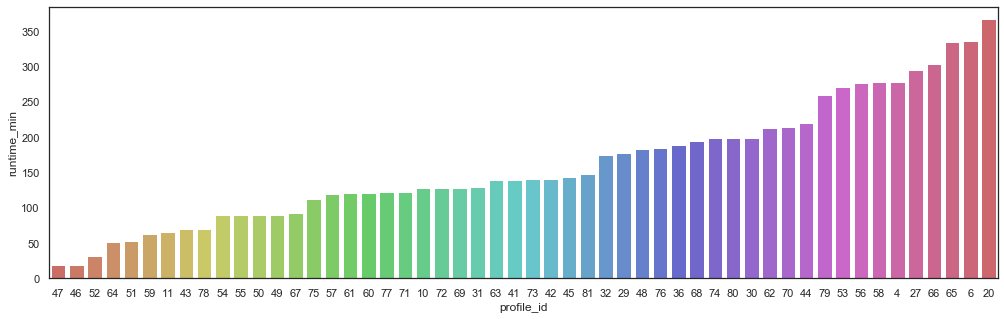

In [8]:
fig = plt.figure(figsize=(17, 5))
sns.barplot(y='runtime_min', x='profile_id', data=df_trials, order=df_trials.sort_values(by='runtime_min')['profile_id'], palette='hls')

the shorted 3 trials, 47, 46, and 52 are each less that 1 hour (<7200 samples), which was the minimum trial length described in the dataset context.  Trial 20 is also over 6 hours, the max trial length described in the context.  

We will attempt to use trials that have representative distributions and are not too short.

We can add the elapsed time of the current trial for each sample.

We can explore the whole dataset.

In [9]:
df_full = df.copy()
df.head()

ambient   coolant       u_d       u_q  motor_speed    torque       i_d  \
0 -0.752143 -1.118446  0.327935 -1.297858    -1.222428 -0.250182  1.029572   
1 -0.771263 -1.117021  0.329665 -1.297686    -1.222429 -0.249133  1.029509   
2 -0.782892 -1.116681  0.332771 -1.301822    -1.222428 -0.249431  1.029448   
3 -0.780935 -1.116764  0.333700 -1.301852    -1.222430 -0.248636  1.032845   
4 -0.774043 -1.116775  0.335206 -1.303118    -1.222429 -0.248701  1.031807   

        i_q        pm  stator_yoke  stator_tooth  stator_winding  profile_id  \
0 -0.245860 -2.522071    -1.831422     -2.066143       -2.018033           4   
1 -0.245832 -2.522418    -1.830969     -2.064859       -2.017631           4   
2 -0.245818 -2.522673    -1.830400     -2.064073       -2.017343           4   
3 -0.246955 -2.521639    -1.830333     -2.063137       -2.017632           4   
4 -0.246610 -2.521900    -1.830498     -2.062795       -2.018145           4   

   sample_id  
0          0  
1          1  
2          2  
3          3  
4          4

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ambient         998070 non-null  float64
 1   coolant         998070 non-null  float64
 2   u_d             998070 non-null  float64
 3   u_q             998070 non-null  float64
 4   motor_speed     998070 non-null  float64
 5   torque          998070 non-null  float64
 6   i_d             998070 non-null  float64
 7   i_q             998070 non-null  float64
 8   pm              998070 non-null  float64
 9   stator_yoke     998070 non-null  float64
 10  stator_tooth    998070 non-null  float64
 11  stator_winding  998070 non-null  float64
 12  profile_id      998070 non-null  int64  
 13  sample_id       998070 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 106.6 MB


There are 998070 total entries. No column has empty or null values.  All values are floats or integers.  

### Measurement Distributions

Next we plot the distribution of each measurement to determine if there are any unusual clumps of data or aberrant patterns.

The input values for voltage and current (u_q, u_d, i_q, i_d) will be interesting to investigate.  Ideally they will have a normal or flat distribution to be representative of all possible inputs. 

The future analysis will focus on the features grouped into lists below.

In [11]:
feat = ['torque', 'motor_speed', 'i_q', 'i_d', 'u_q', 'u_d', 'p_q', 'p_d']
temp = ['pm', 'stator_tooth', 'stator_winding', 'stator_yoke', 'coolant', 'ambient']

### Interaction Feature

The product of current and voltage is power, we will create an interaction variable for this.

In [12]:
df['p_q'] = df['i_q'] * df['u_q']
df['p_d'] = df['i_d'] * df['u_d']

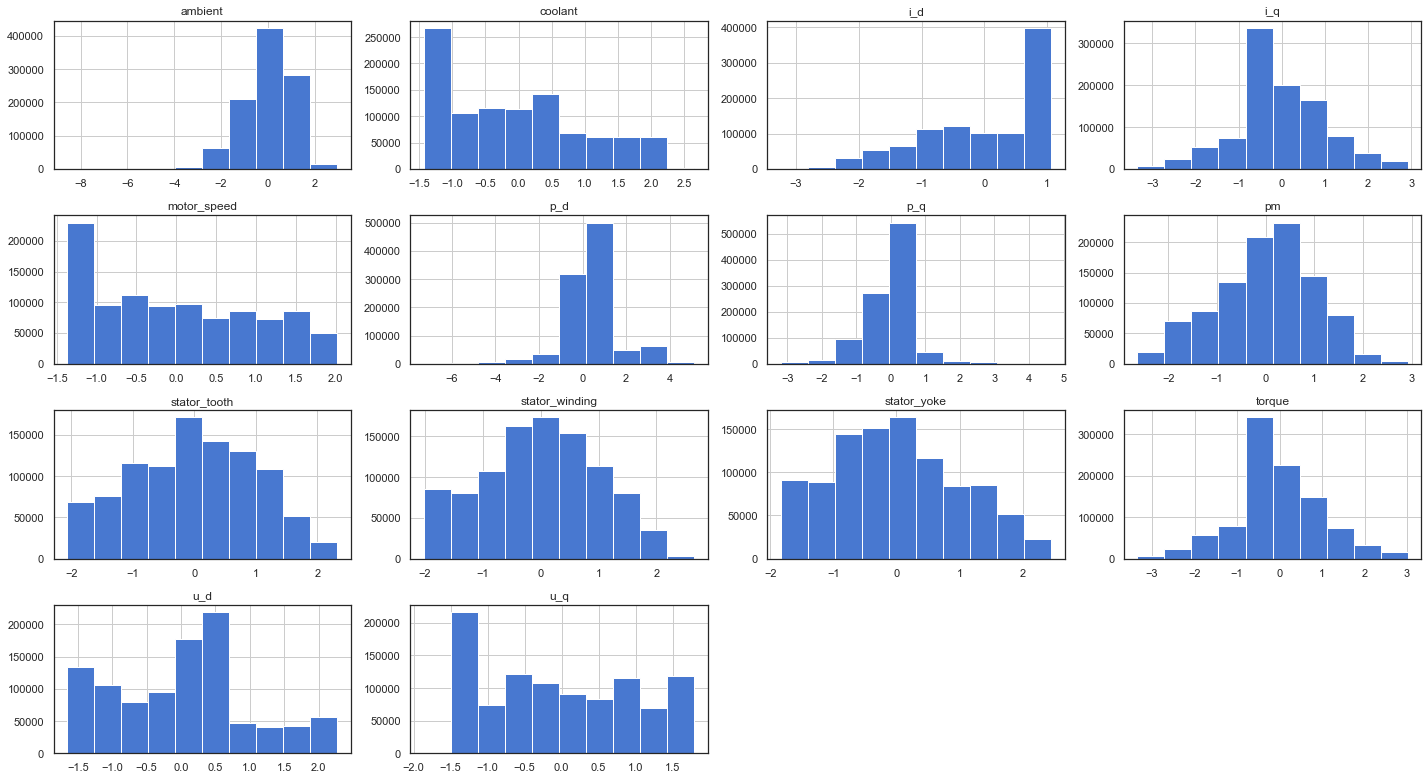

In [13]:
df[feat+temp].hist(figsize = (20,11))
plt.tight_layout()

We can inspect the correlations between features with a heatmap.

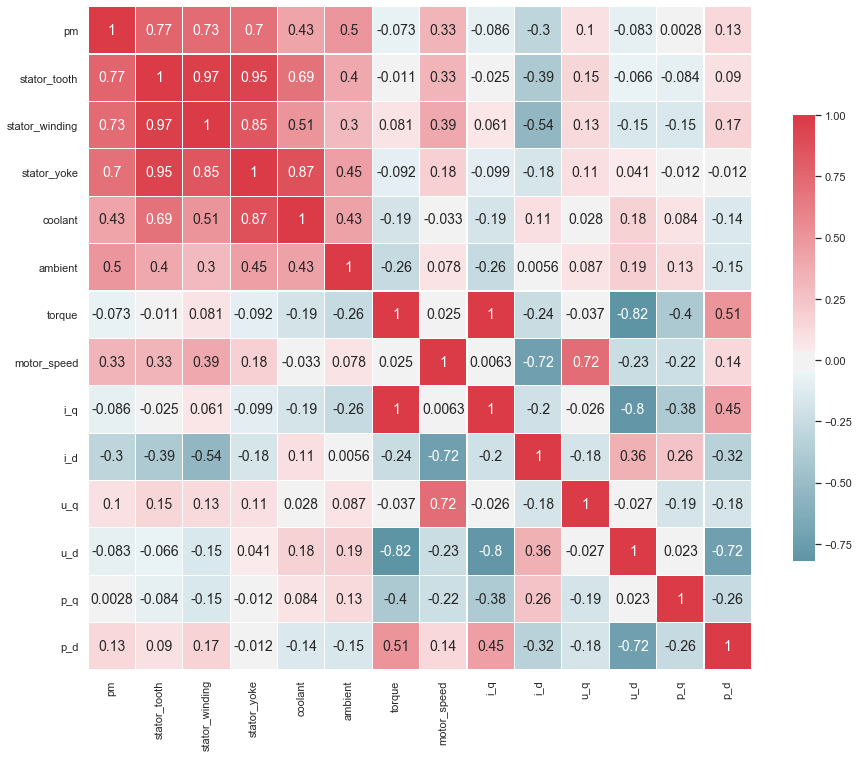

In [14]:
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
plt.figure(figsize=(13,13))
sns.heatmap(df[temp+feat].corr(), cmap= cmap, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .5}, annot = True, annot_kws={"size": 14})
plt.tight_layout()

Examining i_q at low u_q.  All of the low u_q points correspond to i_q of -0.2.

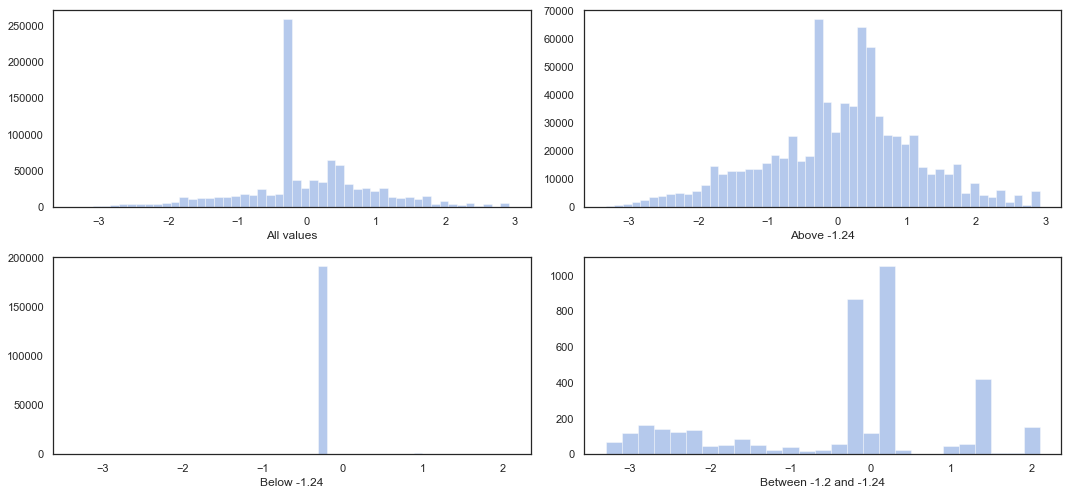

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), sharex=False)
sns.distplot(df['i_q'], kde = False, color="b", ax=axes[0, 0], axlabel = 'All values') #all values
sns.distplot(df['i_q'][(df['u_q'] >= -1.24)], kde = False, color="b", ax=axes[0, 1], axlabel = 'Above -1.24') #values above -1.24, should be normal and high var
sns.distplot(df['i_q'][(df['u_q'] < -1.24)], kde = False, color="b", ax=axes[1, 0], axlabel = 'Below -1.24') #values below -1.24, should be low var
sns.distplot(df['i_q'][(df['u_q'] > -1.24)&(df['u_q'] < -1.2)], kde = False, color="b", ax=axes[1, 1], axlabel = 'Between -1.2 and -1.24') #values between -1.2 and 1.24, should still be high var
plt.tight_layout()

Which trials have an overrepresented set of u_q values below 1.24?

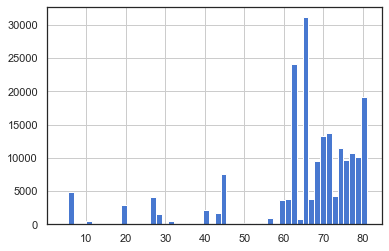

In [16]:
df[(df['u_q'] < -1.24)]['profile_id'].hist(bins=52)

### Examining Trials

This dataset is split into 52 separate trials.  Training models on data across different trials doe not produce accurate preditions.  Instead we will train models on data from the earlier parts of a trial to predict the later datapoints.  

We want to select trials that appear to mimic highway driving.  We will focus on motor speed and torque, looking for frequent fluctuations, and general trends.  We will avoid trials with instantaneous changes in motor speed or torque beccause that does not generally represent human highway drivers.  

We will also track the blue temperature line representing the Rotor Temp (pm).  This is a target feature.  

I will first create a function for displaying the time series plots.

In [17]:
def time_series_gestalt(inx, df, target_features):
    grpd = df.groupby(['profile_id'])

    matplotlib.rcParams.update({'font.size': 12})
    ids_to_plot = inx
    fig2 = plt.figure(figsize=(17, 10))
    cols = len(ids_to_plot)

    for i, (sess_id, _df) in enumerate([g for g in grpd if g[0] in ids_to_plot]):
        _df = _df.reset_index(drop=True)
        plt.subplot(5, cols, i+1)
        plt.xticks([])
        for target in target_features:
            plt.plot(_df[target], label=target)
        if i == 0:
            plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1.0))
        plt.subplot(5, cols, i+1+cols)
        plt.plot(_df['motor_speed'], color='green', label='motor_speed')
        plt.xticks([])
        if i == 0:
            plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1.0))
        plt.subplot(5, cols, i+1+cols*2)
        plt.plot(_df['torque'], color='purple', label='torque')
        plt.xticks([])
        if i == 0:
            plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1.0))
        plt.subplot(5, cols, i+1+cols*3)
        plt.plot(_df['ambient'], color='grey', label='ambient')
        plt.xticks([])
        if i == 0:
            plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1.0))
        plt.subplot(5, cols, i+1+cols*4)
        plt.plot(_df['coolant'], color='cyan', label='coolant')
        k = int(len(_df)> 4*3600) + 1
        plt.xticks(_df['coolant'].index.values[::k*3600], _df.coolant.index.values[::k*3600] / (2*3600))
        plt.xlabel('time in hours')
        if i == 0:
            plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1.0))
    
    plt.tight_layout()

Now we will explore all trials, 4 at a time.  The top plot shows temperature readings, pm in blue.

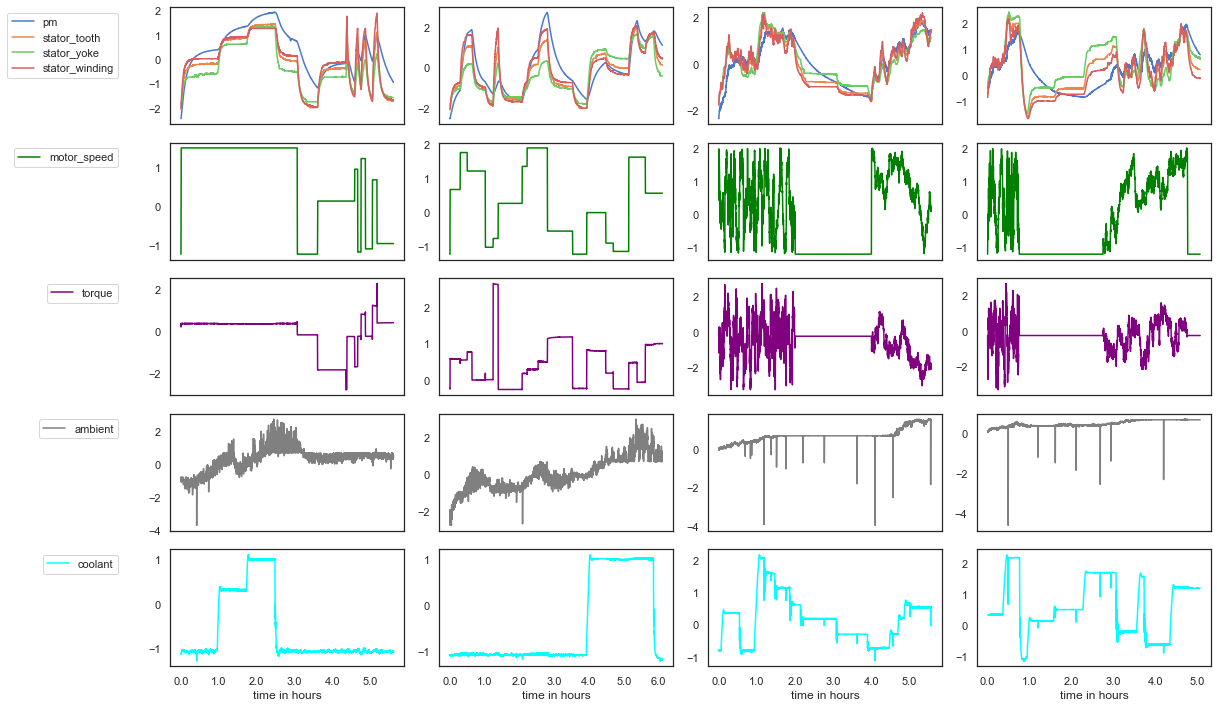

In [18]:
inx_0 = 0
target_features = ['pm', 'stator_tooth', 'stator_yoke', 'stator_winding']
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

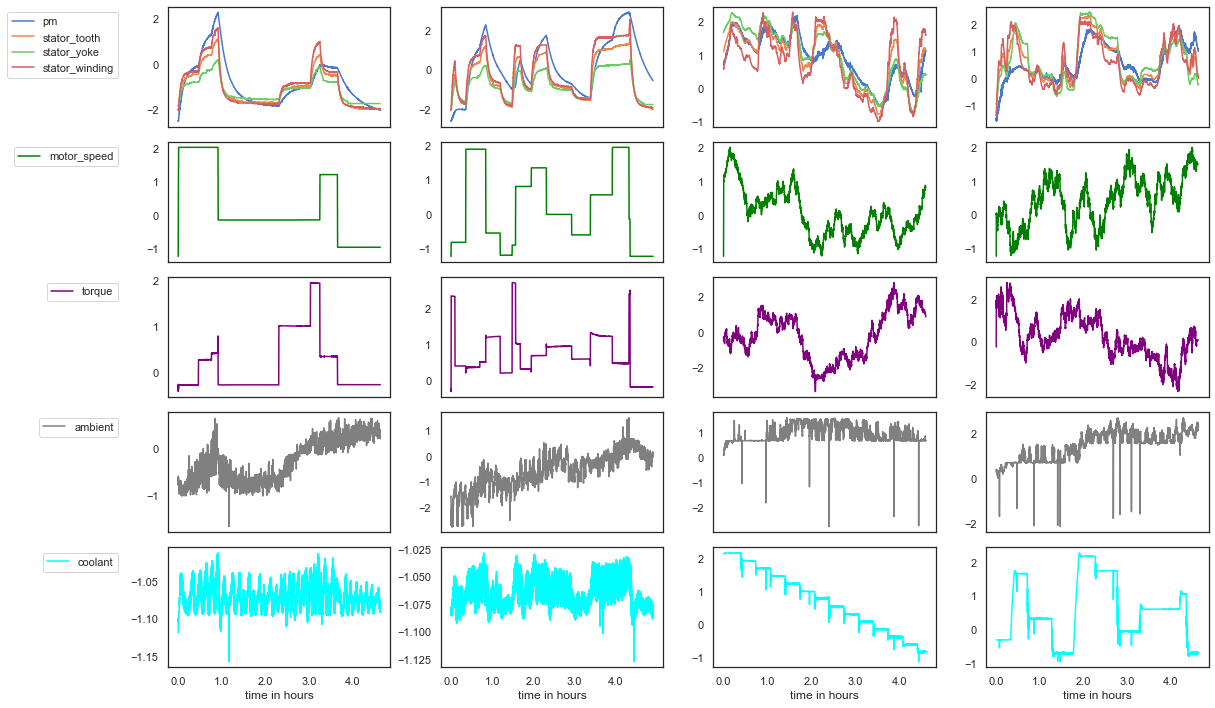

In [19]:
inx_0 = 4
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

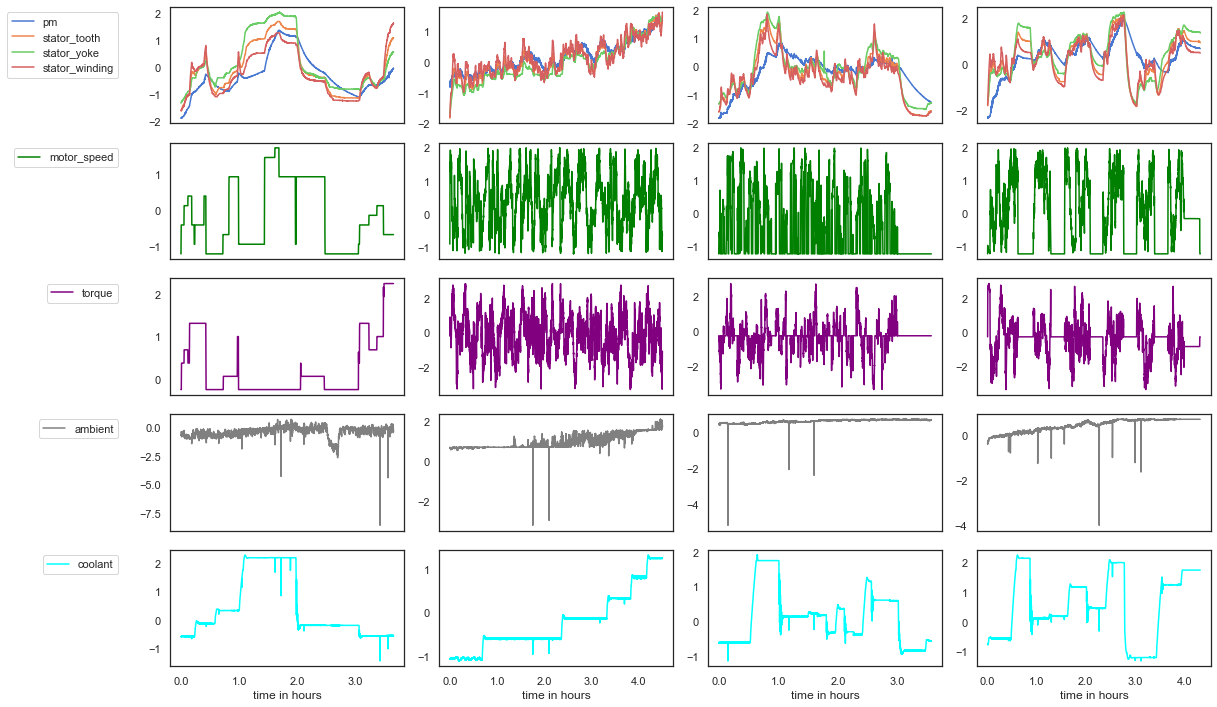

In [20]:
inx_0 = 8
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

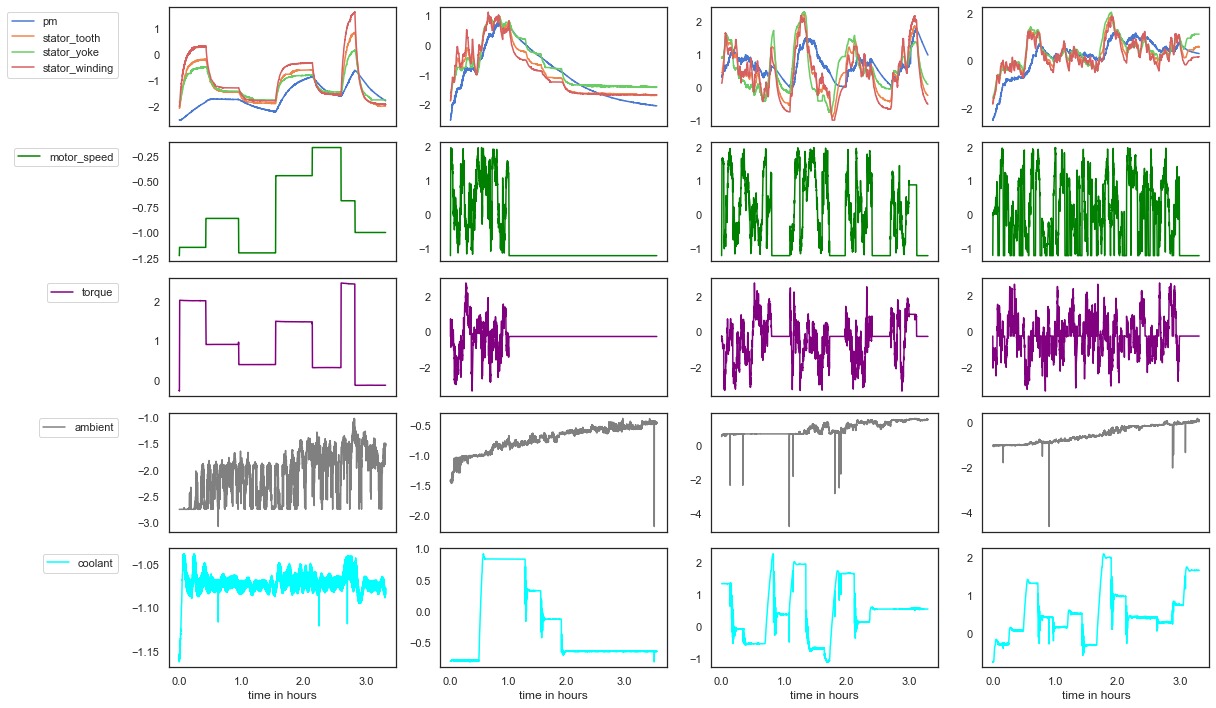

In [21]:
inx_0 = 12
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

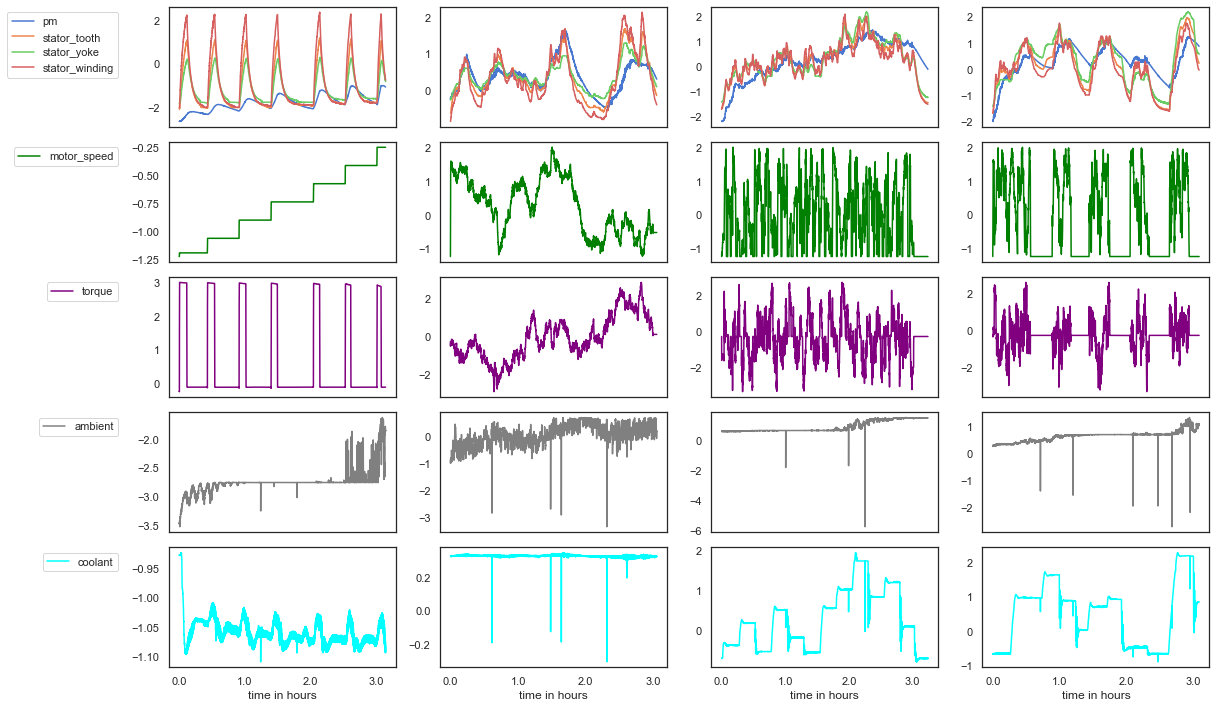

In [22]:
inx_0 = 16
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

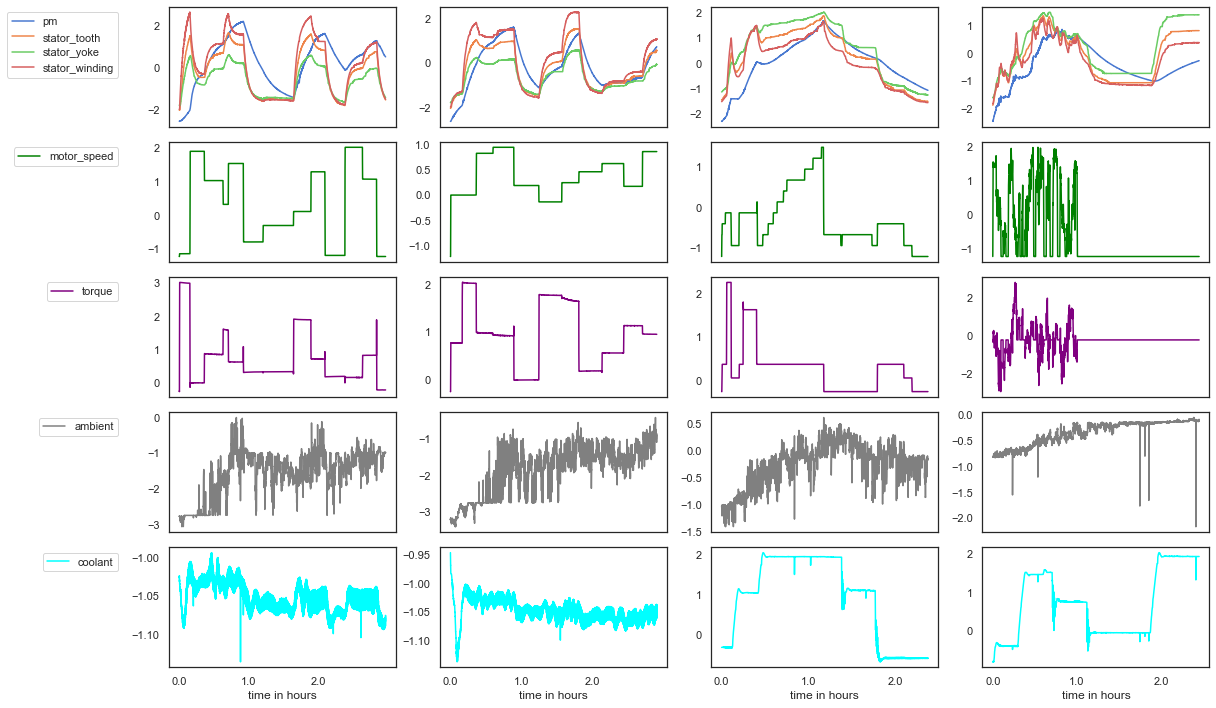

In [23]:
inx_0 = 20
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

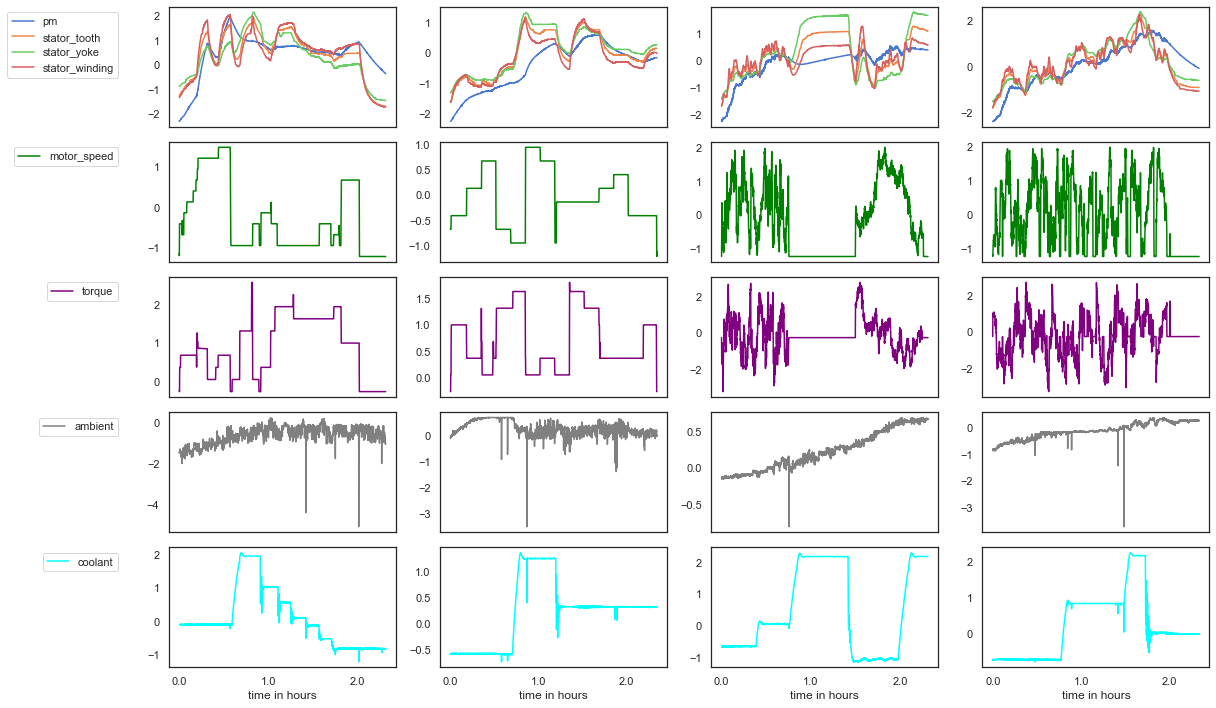

In [24]:
inx_0 = 24
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

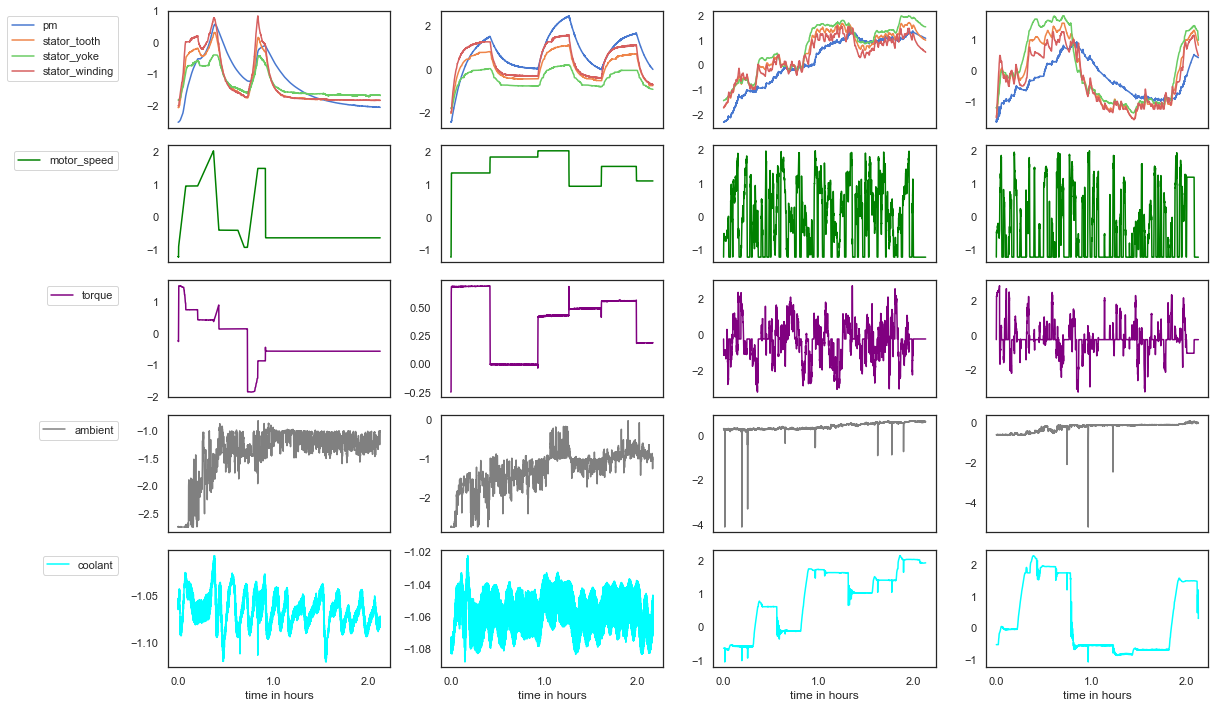

In [25]:
inx_0 = 28
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

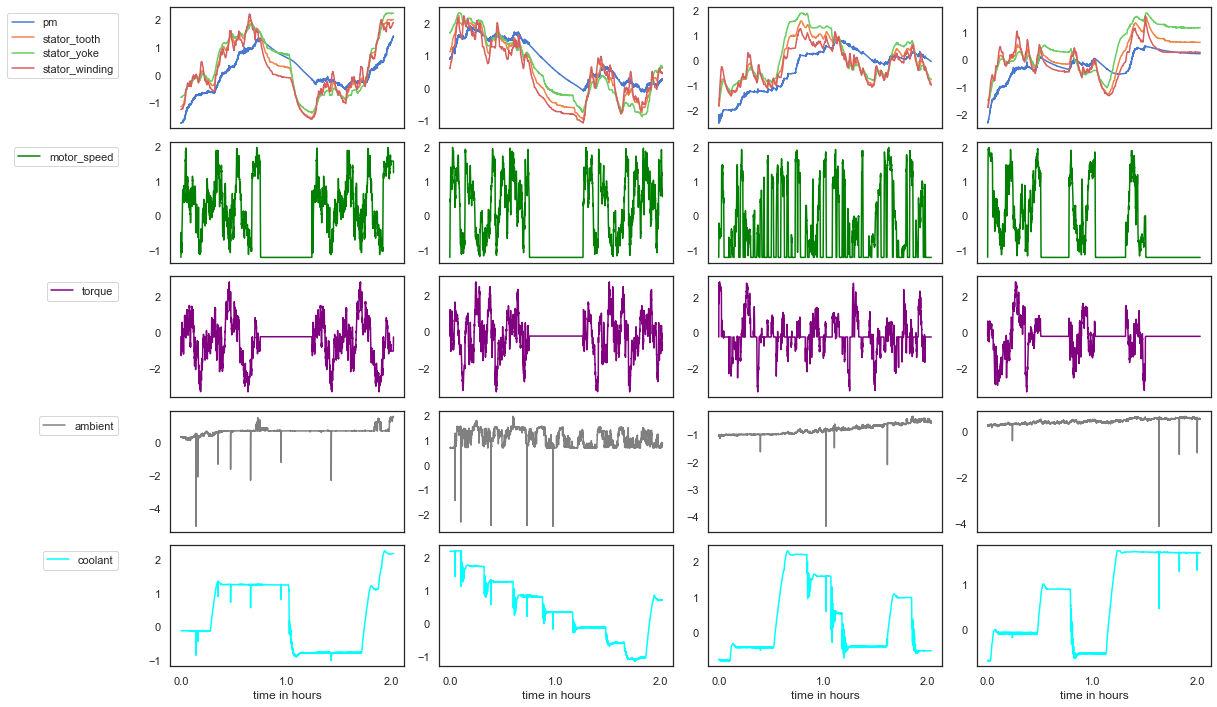

In [26]:
inx_0 = 32
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

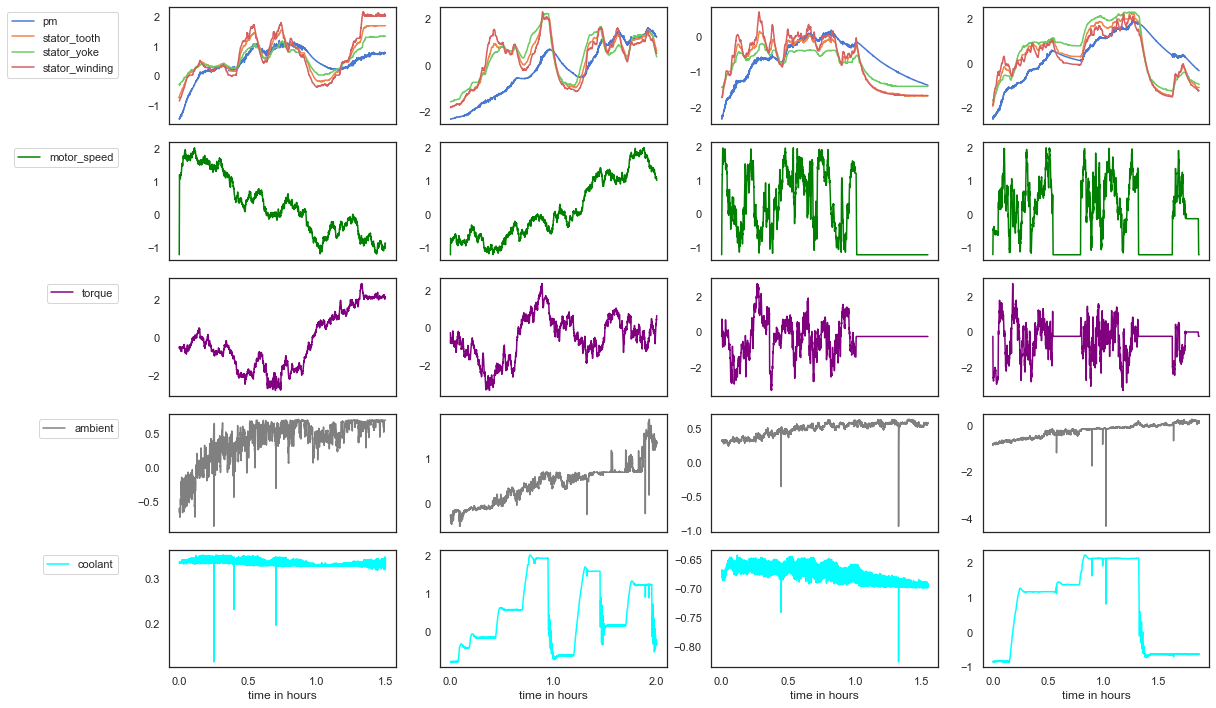

In [27]:
inx_0 = 36
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

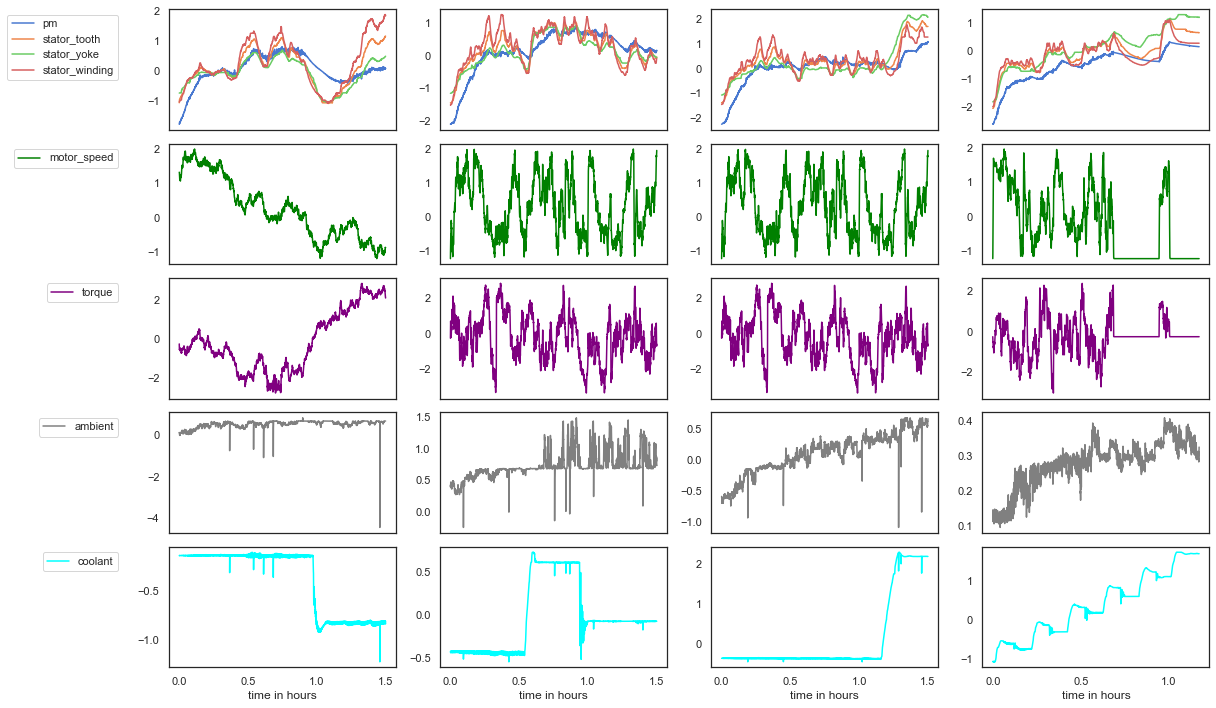

In [28]:
inx_0 = 40
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

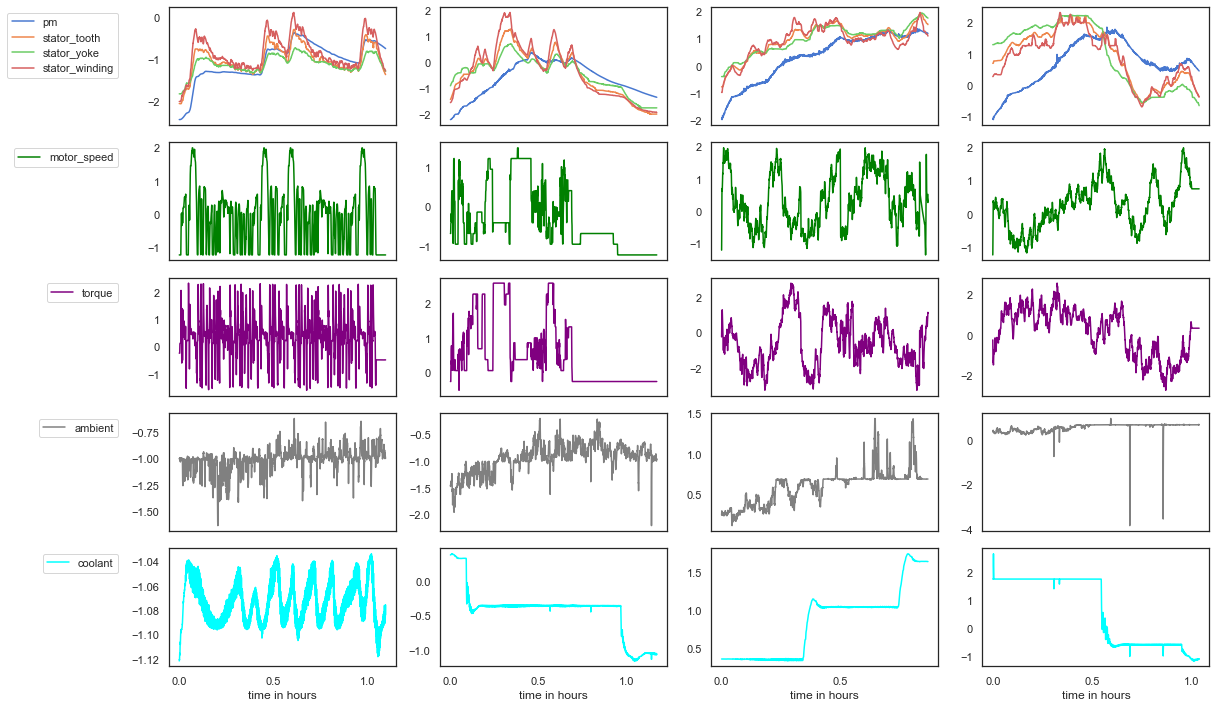

In [29]:
inx_0 = 44
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

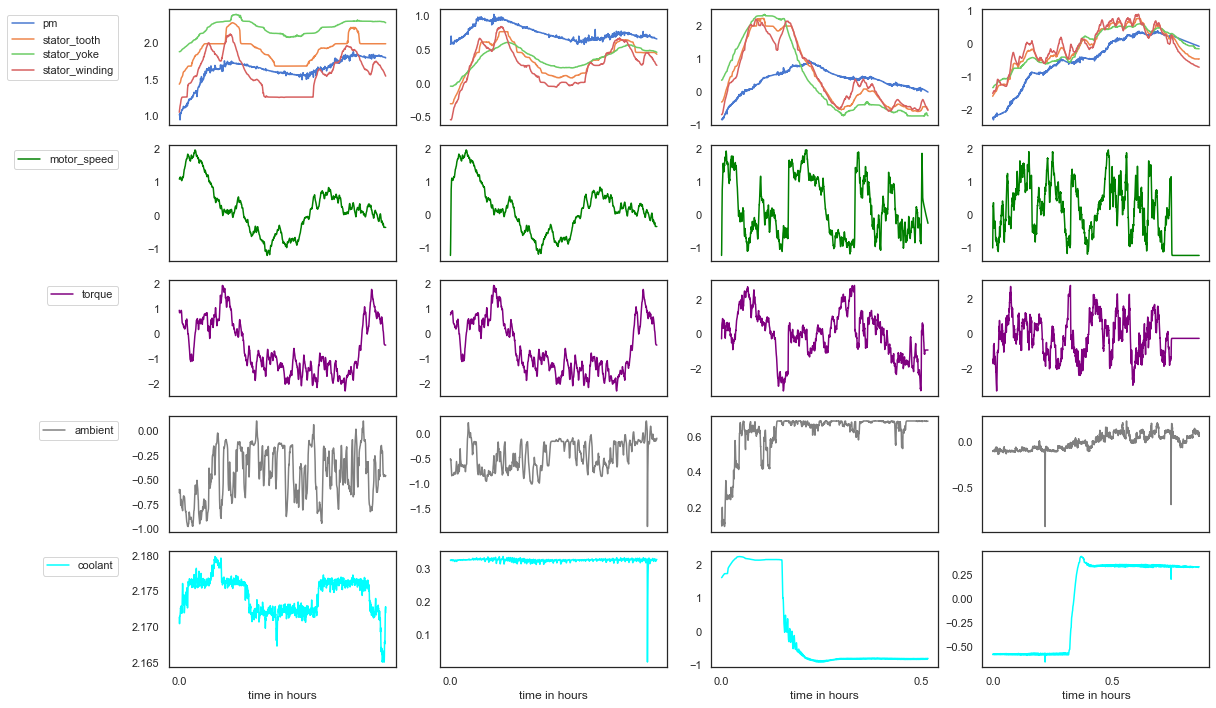

In [30]:
inx_0 = 48
inx = list(df_trials['profile_id'][inx_0:inx_0+4])
time_series_gestalt(inx, df, target_features)

I have selected all trials that appear to represent highway driving behavior.

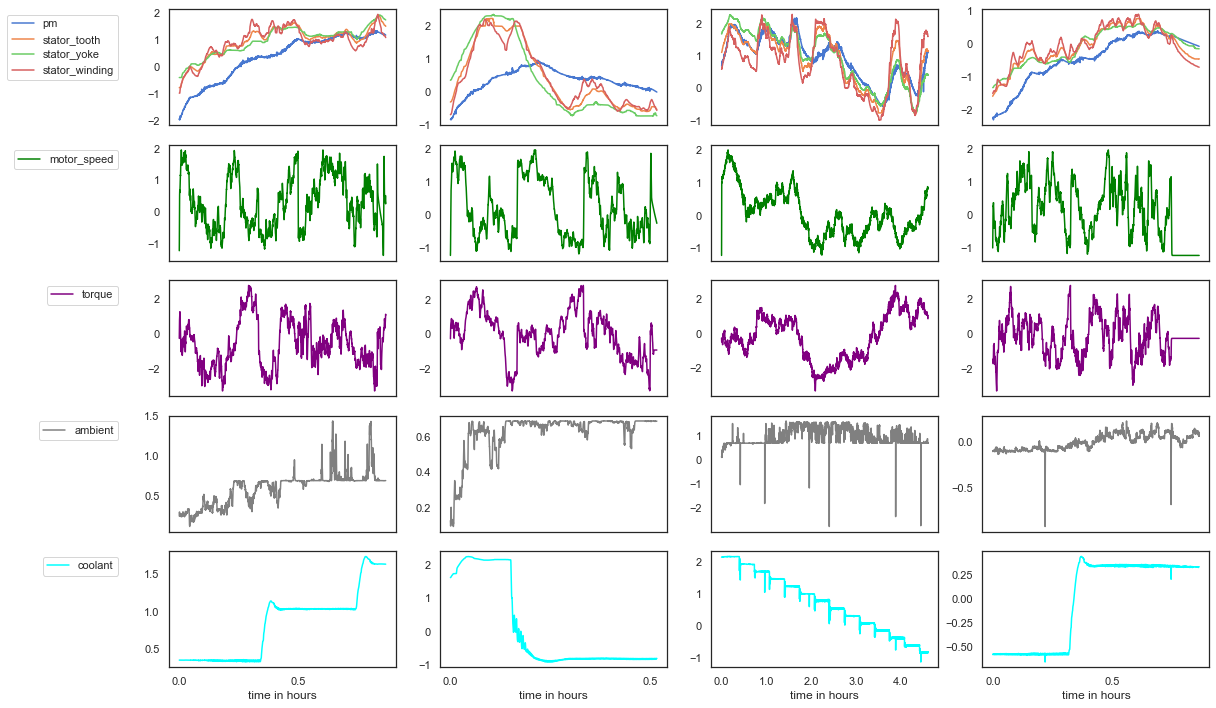

In [31]:
inx = [64, 56, 52, 51]
time_series_gestalt(inx, df, target_features)

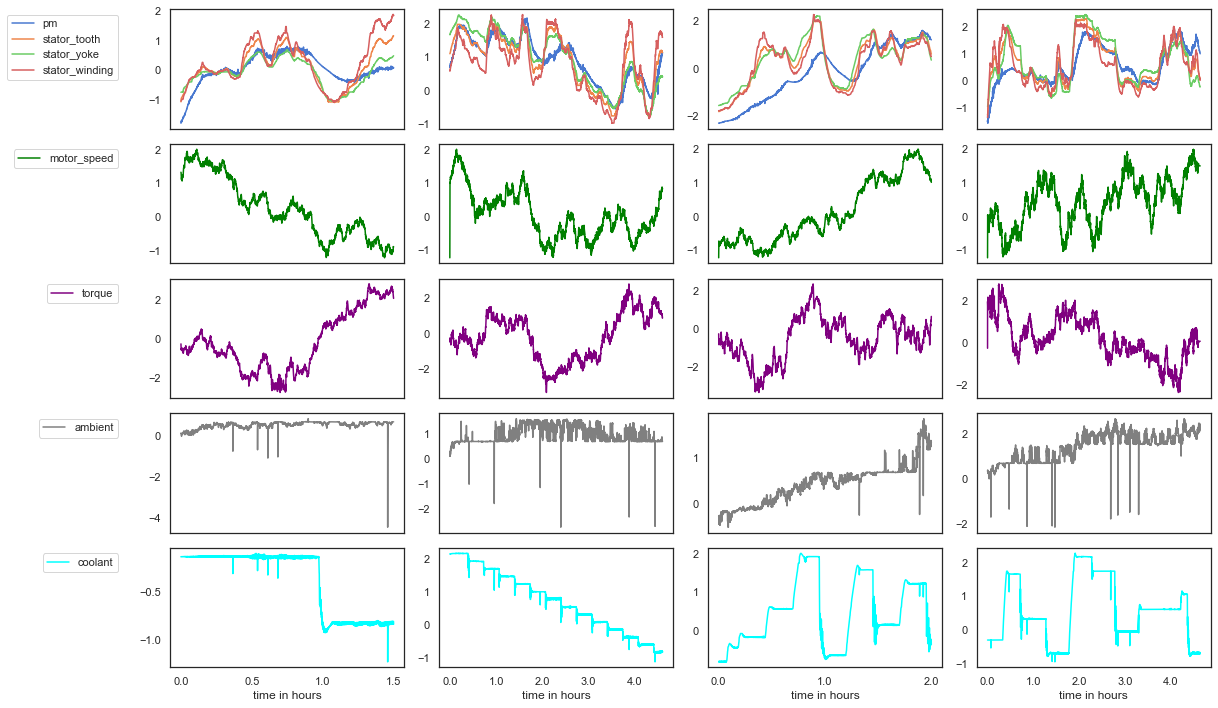

In [32]:
inx = [56, 57, 50, 58]
time_series_gestalt(inx, df, target_features)

These two trials i have selected for further analysis.  However, the models developed below should accept data fram any trial with a long enough runtime.

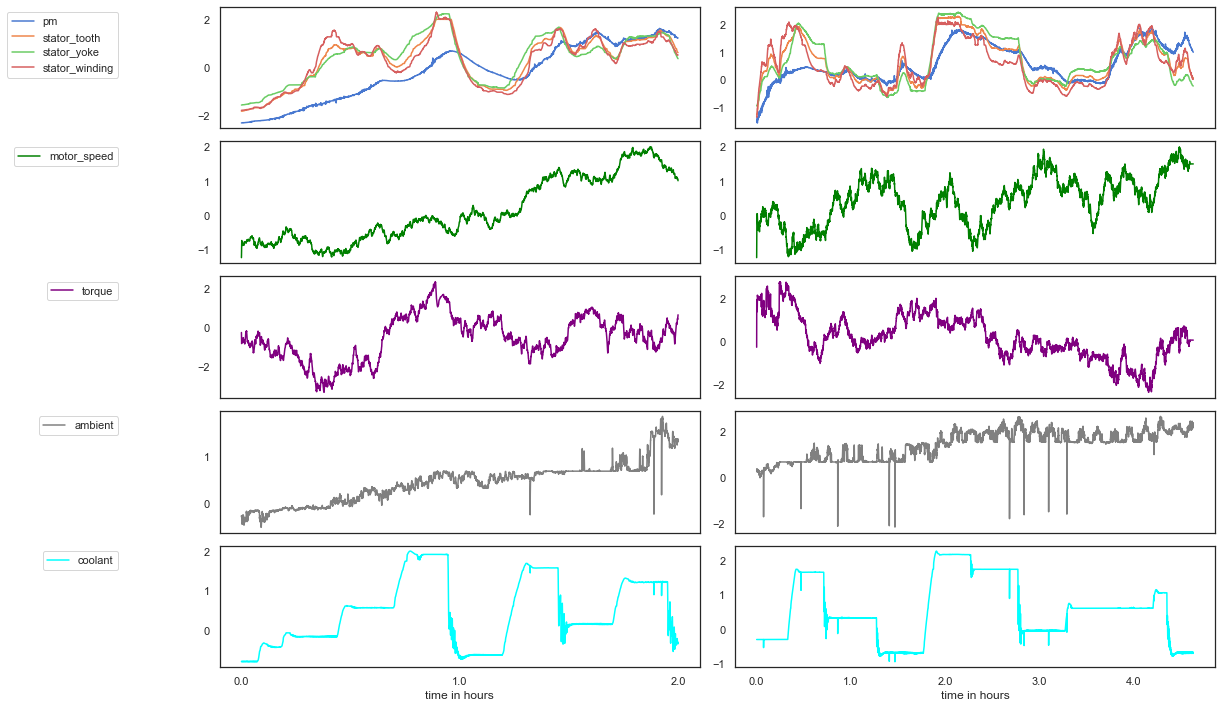

In [33]:
inx = [57, 58]
time_series_gestalt(inx, df, target_features)

We will begin with trial 57.

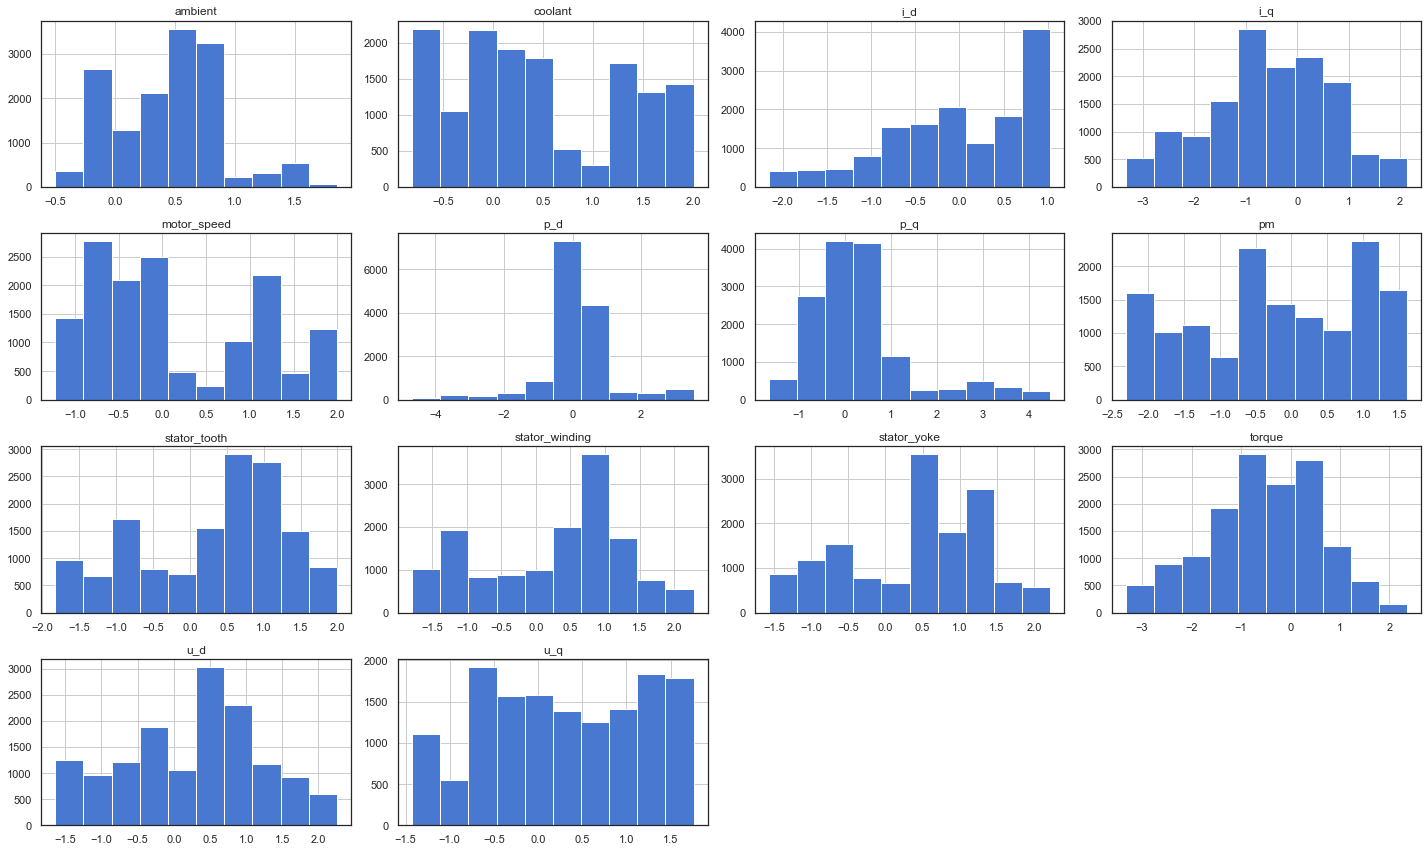

In [34]:
df[temp+feat][df['profile_id'] == 57].hist(figsize = (20,12))
plt.tight_layout()

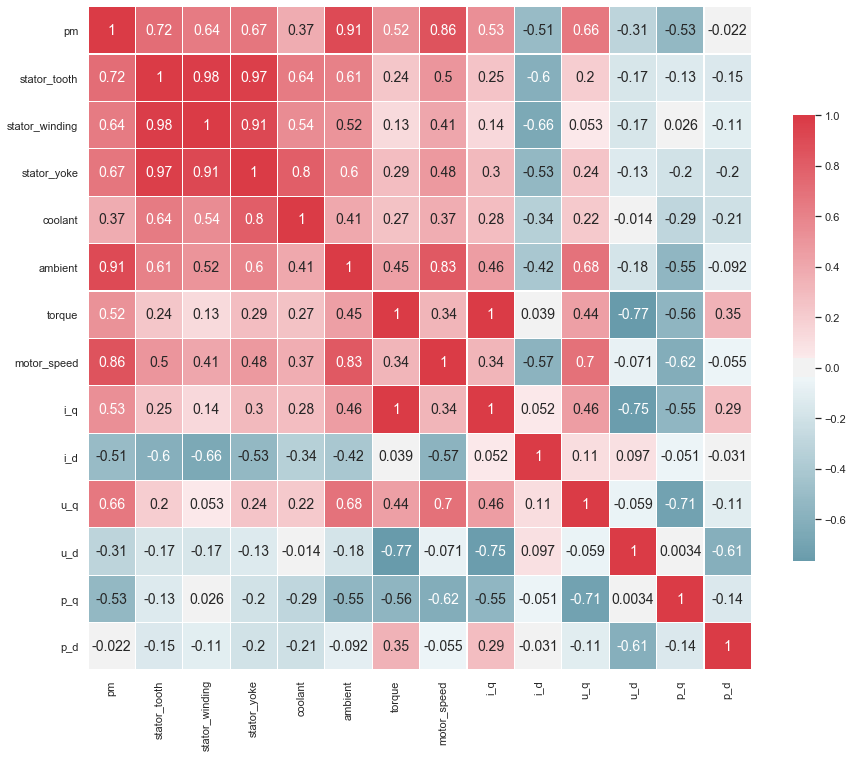

In [35]:
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
plt.figure(figsize=(13,13))
sns.heatmap(df[temp+feat][df['profile_id'] == 57].corr(), cmap= cmap, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .5}, annot = True, annot_kws={"size": 14})
plt.tight_layout()

Does trial 58 have similiar distributions?

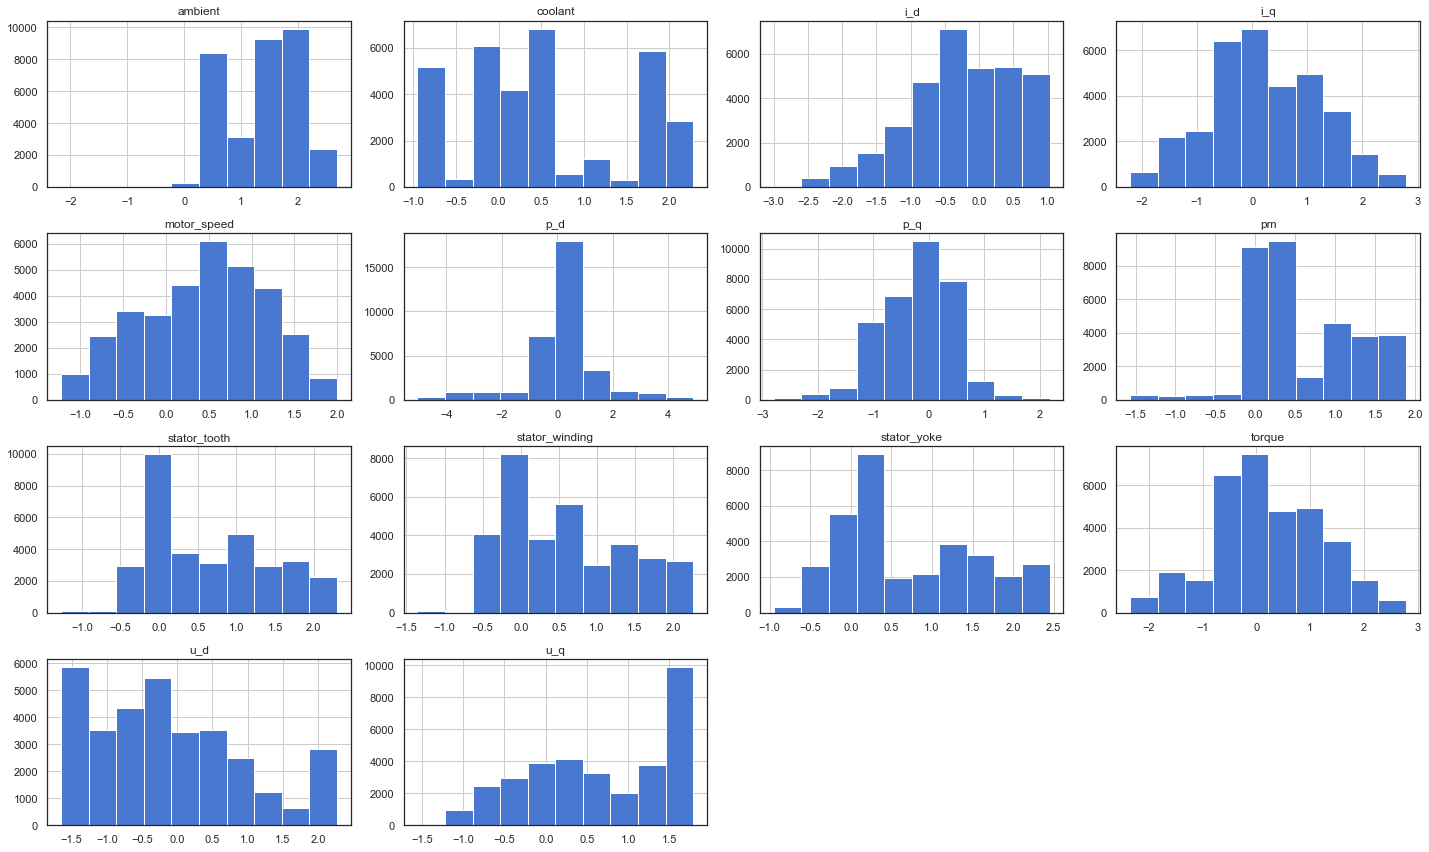

In [36]:
df[temp+feat][df['profile_id'] == 58].hist(figsize = (20,12))
plt.tight_layout()

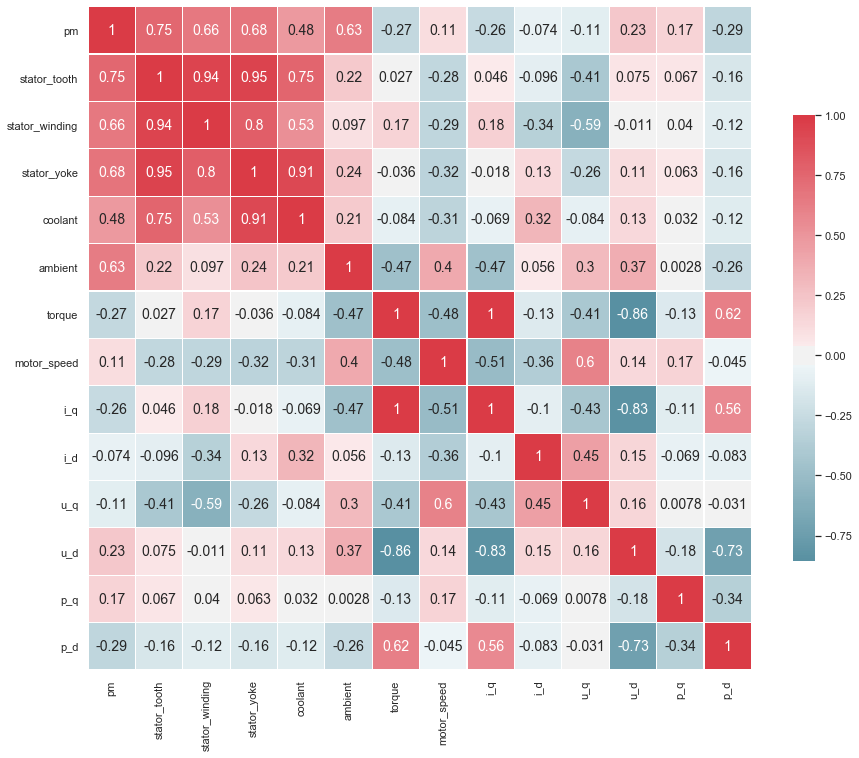

In [37]:
plt.figure(figsize=(13,13))
sns.heatmap(df[temp+feat][df['profile_id'] == 58].corr(), cmap= cmap, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .5}, annot = True, annot_kws={"size": 14})
plt.tight_layout()

Both trials have normal distributions for torque, trial 58 has low representation for lower values of pm.

### Rotor Temperature Forecasting

The goal of these models is to predict 'pm', the temperature of the rotor.  During the trials, rotor temp is read with an infrared sensor.  This method may not be available or reliable in a commercial application.  Thus, having a model to predict rotor temperature by analyzing the other temperature and motor readings will be valuable for preventing dangerous temperatures in the rotor that may be difficult to detect.  

#### Model Preparation

Split the data into train and test sets.

In [38]:
data = df[temp+feat][df['profile_id'] == 57]
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_set, test_set = data.iloc[0:train_size].copy(), data.iloc[train_size:len(data)].copy()
print(train_set.shape, test_set.shape)

(11521, 14) (2881, 14)


We will use MinMaxScaler to scale all features.

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_set)
df_s = pd.DataFrame(scaled, columns=temp+feat)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_s.drop('pm', axis=1), df_s['pm'], test_size = 0.2, shuffle=False)

X_train_cons = sm.add_constant(X_train)

X_test_cons = sm.add_constant(X_test)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 9216
The number of observations in test set is 2305


The print_stats function will print scoring metrics for each models predictions. 
the plot_pred function will plot true vs predicted values.

In [41]:
def print_stats(model, X_train, y_train, X_test, y_test, y_preds_test):
    print("R-squared of the training set: {}".format(model.score(X_train, y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the test set: {}".format(model.score(X_test, y_test)))
    print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [42]:
def plot_pred(y_test, y_preds):
    plt.scatter(y_test, y_preds, alpha = 0.4)
    plt.plot(y_test, y_test, color="red")
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("Charges: true and predicted values")
    plt.show()

#### Ordinary Least Squares

In [43]:
lrm = linear_model.LinearRegression()
lrm.fit(X_train_cons, y_train) # .fit method estimates the coefficients using OLS. 
y_preds = lrm.predict(X_test_cons) # Get predictions.
results = sm.OLS(y_train, X_train_cons).fit() # Display Results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pm   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 2.500e+04
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        12:59:13   Log-Likelihood:                 16346.
No. Observations:                9216   AIC:                        -3.266e+04
Df Residuals:                    9202   BIC:                        -3.256e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.4993      0.092     27.042      0.000       2.318       2.680
stator_tooth       1.4693      0.040     36.496      0.000       1.390       1.548
stator_winding    -0.6370      0.023    -27.666      0.000      -0.682      -0.592
stator_yoke       -0.4165      0.031    -13.352      0.000      -0.478      -0.355
coolant           -0.1525      0.007    -23.224      0.000      -0.165      -0.140
ambient            0.5208      0.007     79.475      0.000       0.508       0.534
torque            -0.3000      0.206     -1.458      0.145      -0.703       0.103
motor_speed       -1.0133      0.063    -16.195      0.000      -1.136      -0.891
i_q               -0.8525      0.198     -4.297      0.000      -1.241      -0.464
i_d               -0.3932      0.020    -19.775      0.000      -0.432      -0.354
u_q                0.7471      0.039     18.959      0.000       0.670       0.824
u_d               -1.2312      0.049    -25.034      0.000      -1.328      -1.135
p_q               -1.3090      0.045    -28.855      0.000      -1.398      -1.220
p_d               -0.9553      0.048    -19.973      0.000      -1.049      -0.862
==============================================================================
Omnibus:                       76.184   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.556
Skew:                          -0.177   Prob(JB):                     4.77e-16
Kurtosis:                       2.760   Cond. No.                     1.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

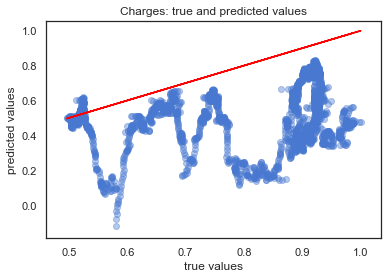

R-squared of the training set: 0.9724656906941692
-----Test set statistics-----
R-squared of the test set: -4.72687610358284
Mean absolute error of the prediction: 0.2979598272695475
Mean squared error of the prediction: 0.12404177791406883
Root mean squared error of the prediction: 0.35219565288922694
Mean absolute percentage error of the prediction: 36.217163128450515


In [44]:
y_preds = results.predict(X_test_cons)
plot_pred(y_test, y_preds)
print_stats(lrm, X_train_cons, y_train, X_test_cons, y_test, y_preds)

This high training R squared compared to the negative test r squared implies this model is overfit to training data.  

#### Ridge Regression (L2)

When applying Ridge regression, we must specify a lambda value (alpha in python).  In this analysis, we will use RidgeCV to identify the best value.

Our cross valication set must not be randomly samples, we want earlier samples in the training set. Thus the KFold must have shuffle = False.

In [45]:
cv = KFold(5, shuffle=False)

In [46]:
ridgeCVregr = RidgeCV(alphas = np.logspace(start = -4, stop = 3, base = 2), cv = cv)
ridgeCVregr.fit(X_train, y_train)
y_preds_train = ridgeCVregr.predict(X_train)
y_preds_test = ridgeCVregr.predict(X_test)
ridgeCVregr.alpha_

0.0625

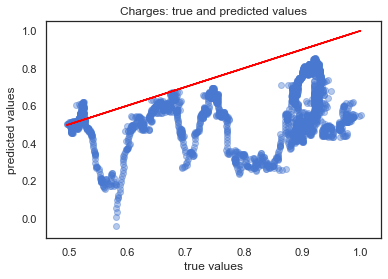

R-squared of the training set: 0.9723636318603252
-----Test set statistics-----
R-squared of the test set: -2.919057881709
Mean absolute error of the prediction: 0.24243299319508954
Mean squared error of the prediction: 0.0848851797389525
Root mean squared error of the prediction: 0.2913506130746124
Mean absolute percentage error of the prediction: 29.341347922078548


In [47]:
plot_pred(y_test, y_preds_test)
print_stats(ridgeCVregr, X_train, y_train, X_test, y_test, y_preds_test)

#### Lasso Regression (L1)

When applying Lasso regression, we must similarly specify a lambda value (alpha in python).  In this analysis, we will use LassoCV to identify the best value.

In [48]:
lassoCVregr = LassoCV(alphas = np.logspace(start = -11, stop = 2, base = 2), cv=cv)#, tol = 0.1)
lassoCVregr.fit(X_train, y_train)
y_preds_train = lassoCVregr.predict(X_train)
y_preds_test = lassoCVregr.predict(X_test)
lassoCVregr.alpha_

0.00048828125

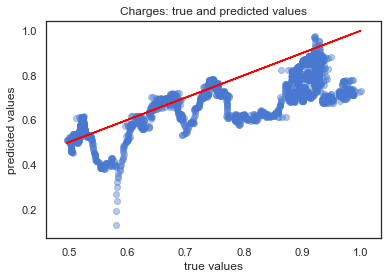

R-squared of the training set: 0.9628082935772222
-----Test set statistics-----
R-squared of the test set: 0.26788894769615923
Mean absolute error of the prediction: 0.09847240093160801
Mean squared error of the prediction: 0.01585722388886616
Root mean squared error of the prediction: 0.1259254695796929
Mean absolute percentage error of the prediction: 11.910139519860522


In [49]:
plot_pred(y_test, y_preds_test)
print_stats(lassoCVregr, X_train, y_train, X_test, y_test, y_preds_test)

#### Elastinet Regression (L1 + L2)

ElasticNet combines the two previous regularization techniques.  For this analysis we willuse logspace to test l1 ratios and ElasticNetCV to choose alpha. 

In [50]:
elasticCVregr = ElasticNetCV(l1_ratio=np.logspace(start = -8, stop = 0, base = 2), cv=cv)  #tuned (0.1, 0.5, 0.05, 0.001, 0.005)
elasticCVregr.fit(X_train, y_train)
y_preds_train = elasticCVregr.predict(X_train)
y_preds_test = elasticCVregr.predict(X_test)
elasticCVregr.alpha_

0.00027915206565453613

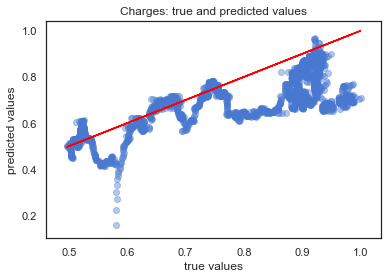

R-squared of the training set: 0.9637151510324652
-----Test set statistics-----
R-squared of the test set: 0.2748295608079504
Mean absolute error of the prediction: 0.09545122711309138
Mean squared error of the prediction: 0.015706893067205525
Root mean squared error of the prediction: 0.12532714417557564
Mean absolute percentage error of the prediction: 11.413024443680834


In [51]:
plot_pred(y_test, y_preds_test)
print_stats(elasticCVregr, X_train, y_train, X_test, y_test, y_preds_test)

#### Random Forest

For comparison to the regression techniques shown, we will implement a random forest model aswell. WGridSearchCV will allow us to test a some combinations of parameters.  This has long runtime with two many parameter choices.  

In [52]:
rfr = ensemble.RandomForestRegressor() 
#parameters = { 'max_features':np.arange(5,(len(temp+feat)-1)),'n_estimators':[500,50],'min_samples_leaf':[10,50,100,200],'max_depth':np.arange(5, 15),'criterion':['mae', 'mse']}
parameters = { 'max_features':np.arange(5,(len(temp+feat)-1)),'n_estimators':[10],'min_samples_leaf':[50],'max_depth':[5],'criterion':['mae', 'mse']}
rfr_cv = GridSearchCV(rfr, parameters, cv = cv)
rfr_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             ve

In [53]:
rfr_cv.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 5,
 'min_samples_leaf': 50,
 'n_estimators': 10}

In [54]:
y_preds_train = rfr_cv.predict(X_train)
y_preds_test = rfr_cv.predict(X_test)

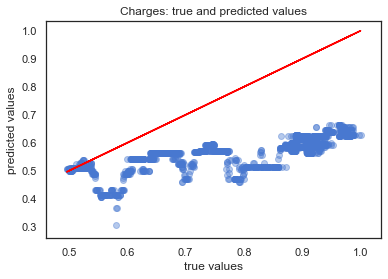

R-squared of the training set: 0.9935394521908637
-----Test set statistics-----
R-squared of the test set: -1.7930316305984995
Mean absolute error of the prediction: 0.21934410497033185
Mean squared error of the prediction: 0.06049591486935265
Root mean squared error of the prediction: 0.2459591731758599
Mean absolute percentage error of the prediction: 25.924265200132563


In [55]:
plot_pred(y_test, y_preds_test)
print_stats(rfr_cv, X_train, y_train, X_test, y_test, y_preds_test)

This model is extremely overfit and does not perform well on test data, even with limited esimators and depth. With more tuning I may be able to develop a better model by testing other parameters, but it still wouldn't account for recent data like a nueral network can.  

### Time Series Forecasting

The models already shown simply look at each datapoint in the test set independently.  However, temperature changes slowly, the model should be able to account for earlier observations.  A Long Short Term Memory network should be able to achieve that goal.

#### LSTM in Keras and Tensorflow using all features

We will design a recurrent neural network that looks at datapoints within a time window of the current timestep.  

we will begin by creating a training set on first 80% of datapoints and a test set on last 20%.

In [56]:
data = df[temp+feat][df['profile_id'] == 57]
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_set, test_set = data.iloc[0:train_size].copy(), data.iloc[train_size:len(data)].copy()
print(train_set.shape, test_set.shape)

(11521, 14) (2881, 14)


In [57]:
dataset = train_set.copy()
#data after 30 minutes warm up
dataset = dataset[3600:]
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [58]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [59]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    frame = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(frame.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(frame.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [60]:
scaled.shape

(7921, 14)

The data has 14 features.  We will have a window of the last 300 samples (2 minutes 30 sec) in the recurrent neural network.  

In [61]:
# specify the number of lag samples
n_samples = 300 # half seconds memory
n_features = 14
# frame as supervised learning
reframed = series_to_supervised(scaled, n_samples, 1)
print(reframed.shape)

(7621, 4214)


Create validation sets and reshape tensors.

In [62]:
# split into train and test sets
values = reframed.values
n_train_samples = int(values.shape[0]*0.8)
train = values[:n_train_samples, :]
test = values[n_train_samples:, :]
# split into input and outputs
n_obs = n_samples * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_samples, n_features))
test_X = test_X.reshape((test_X.shape[0], n_samples, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(6096, 4200) 6096 (6096,)
(6096, 300, 14) (6096,) (1525, 300, 14) (1525,)


Create a Long Short Term Memory Recurrent Neural Network with 64 layers, then one dense sequential RNN. 

In [63]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# I have tuned LSTM(n, could add Dropout regularization

In [64]:
# takes 10 mins
time_start = time.time()

# fit network
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='min') #reduce patience or cap epochs to redcue runtime
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_split=0.2, callbacks=[es], verbose=2, shuffle=False)

print('Time elapsed: {} seconds'.format(time.time()-time_start))


Train on 4876 samples, validate on 1220 samples
Epoch 1/50
 - 14s - loss: 0.0492 - val_loss: 0.2782
Epoch 2/50
 - 13s - loss: 0.1277 - val_loss: 0.2894
Epoch 3/50
 - 13s - loss: 0.1640 - val_loss: 0.1455
Epoch 4/50
 - 13s - loss: 0.1060 - val_loss: 0.1294
Epoch 5/50
 - 13s - loss: 0.1030 - val_loss: 0.1757
Epoch 6/50
 - 13s - loss: 0.0853 - val_loss: 0.2207
Epoch 7/50
 - 13s - loss: 0.0786 - val_loss: 0.2535
Epoch 8/50
 - 13s - loss: 0.0914 - val_loss: 0.0893
Epoch 9/50
 - 13s - loss: 0.0730 - val_loss: 0.1321
Epoch 10/50
 - 14s - loss: 0.0870 - val_loss: 0.1481
Epoch 11/50
 - 14s - loss: 0.0979 - val_loss: 0.1036
Epoch 12/50
 - 13s - loss: 0.0889 - val_loss: 0.0520
Epoch 13/50
 - 13s - loss: 0.0645 - val_loss: 0.0297
Epoch 14/50
 - 13s - loss: 0.0533 - val_loss: 0.0214
Epoch 15/50
 - 15s - loss: 0.0416 - val_loss: 0.0251
Epoch 16/50
 - 14s - loss: 0.0342 - val_loss: 0.0261
Epoch 17/50
 - 14s - loss: 0.0391 - val_loss: 0.0608
Epoch 18/50
 - 13s - loss: 0.0610 - val_loss: 0.0571
Epoch 

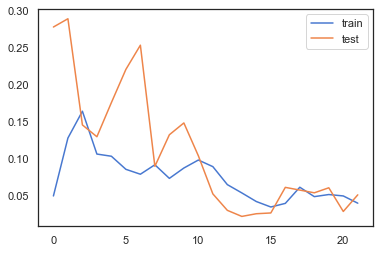

In [65]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

The blue line is the loss function that each epoch attempted to minimize.  The orange line is loss calculate from the validation set.  Since both losses trend downward and level out it appears this model trained well.

How accurate are the predictions on the test data?

In [66]:
# Run train test split before rerunning this cell
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_samples*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate Error
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(inv_y, inv_yhat)))
print("Mean squared error of the prediction: {}".format(mse(inv_y, inv_yhat)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100))
print('R-squared of the test set: {}'.format(r2_score(inv_y, inv_yhat)))

Mean absolute error of the prediction: 0.1631815880537033
Mean squared error of the prediction: 0.04108578711748123
Root mean squared error of the prediction: 0.2459591731758599
Mean absolute percentage error of the prediction: 19.132235646247864
R-squared of the test set: 0.29170162360920016


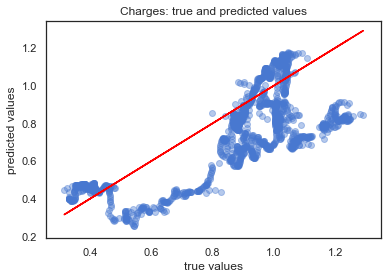

In [67]:
plot_pred(inv_y, inv_yhat)

We can see that many true values are higher than predicted values.  This is not desirable.  The r squared value on the test data is also 0.  This seems to be overfit to training data, perhaps that could be solved with fewer features?

What about data from another trial?

In [68]:
df[feat][df['profile_id'] == 58].shape

(33381, 8)

In [69]:
data = df[temp+feat][df['profile_id'] == 58]

dataset = data.copy()
#data after 30 minutes warm up
dataset = dataset[3600:]
values = dataset.values
# ensure all data is float
values = values.astype('float32')

scaled = scaler.transform(values)

# specify the number of lag samples
n_samples = 300 # half seconds memory
n_features = 14
# frame as supervised learning
reframed = series_to_supervised(scaled, n_samples, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_samples = int(values.shape[0]*0.8)
train = values[:n_train_samples, :]
test = values[n_train_samples:, :]
# split into input and outputs
n_obs = n_samples * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_samples, n_features))
test_X = test_X.reshape((test_X.shape[0], n_samples, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# Run train test split before rerunning this cell
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_samples*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


(29481, 4214)
(23584, 4200) 23584 (23584,)
(23584, 300, 14) (23584,) (5897, 300, 14) (5897,)


In [70]:
# calculate errors
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(inv_y, inv_yhat)))
print("Mean squared error of the prediction: {}".format(mse(inv_y, inv_yhat)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100))
print('R-squared of the test set: {}'.format(r2_score(inv_y, inv_yhat)))

Mean absolute error of the prediction: 0.24338240921497345
Mean squared error of the prediction: 0.08983108401298523
Root mean squared error of the prediction: 0.2459591731758599
Mean absolute percentage error of the prediction: 17.16373562812805
R-squared of the test set: -0.15437894876122882


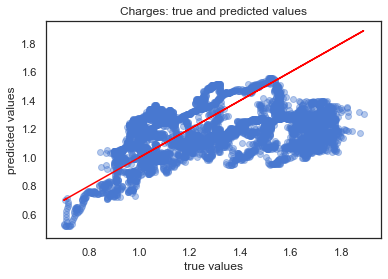

In [71]:
plot_pred(inv_y, inv_yhat)

Surprisingly, this seems to predict better on data from the other trial than on the test data taken from the end of the first trial.  With a test R quared of 0.4 this model is not exceptionally accurate, but could be useful for monitoring rotor temperature.  

#### Rotor Temperature Forecasting from Thermal Sensors

What if we limit the features to only the thermal sensor readings?

In [72]:
data = df[temp][df['profile_id'] == 57]
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_set, test_set = data.iloc[0:train_size].copy(), data.iloc[train_size:len(data)].copy()
print(train_set.shape, test_set.shape)

(11521, 6) (2881, 6)


In [73]:
dataset = train_set.copy()
#data after 30 minutes warm up
dataset = dataset[3600:]
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [74]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [75]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    frame = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(frame.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(frame.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [76]:
scaled.shape

(7921, 6)

The data has 6 features.  We will have a window of the last 300 samples (2 minutes 30 sec) in the recurrent neural network.  

In [77]:
# specify the number of lag samples
n_samples = 300 # half seconds memory
n_features = 6
# frame as supervised learning
reframed = series_to_supervised(scaled, n_samples, 1)
print(reframed.shape)

(7621, 1806)


Create validation sets and reshape tensors.

In [78]:
# split into train and test sets
values = reframed.values
n_train_samples = int(values.shape[0]*0.8)
train = values[:n_train_samples, :]
test = values[n_train_samples:, :]
# split into input and outputs
n_obs = n_samples * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_samples, n_features))
test_X = test_X.reshape((test_X.shape[0], n_samples, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(6096, 1800) 6096 (6096,)
(6096, 300, 6) (6096,) (1525, 300, 6) (1525,)


Create a Long Short Term Memory Recurrent Neural Network with 64 layers, then one dense sequential RNN. 

In [79]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# I have tuned LSTM(n, could add Dropout regularization

In [80]:
# takes 10 mins
time_start = time.time()

# fit network
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='min') #reduce patience or cap epochs to redcue runtime
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_split=0.2, callbacks=[es], verbose=2, shuffle=False)

print('Time elapsed: {} seconds'.format(time.time()-time_start))

Train on 4876 samples, validate on 1220 samples
Epoch 1/50
 - 12s - loss: 0.0407 - val_loss: 0.4584
Epoch 2/50
 - 12s - loss: 0.1138 - val_loss: 0.3801
Epoch 3/50
 - 13s - loss: 0.1095 - val_loss: 0.3299
Epoch 4/50
 - 14s - loss: 0.1152 - val_loss: 0.3456
Epoch 5/50
 - 13s - loss: 0.1100 - val_loss: 0.3548
Epoch 6/50
 - 12s - loss: 0.1036 - val_loss: 0.2480
Epoch 7/50
 - 13s - loss: 0.0814 - val_loss: 0.1520
Epoch 8/50
 - 13s - loss: 0.0638 - val_loss: 0.0551
Epoch 9/50
 - 13s - loss: 0.0492 - val_loss: 0.0631
Epoch 10/50
 - 14s - loss: 0.0315 - val_loss: 0.0580
Epoch 11/50
 - 13s - loss: 0.0171 - val_loss: 0.0236
Epoch 12/50
 - 13s - loss: 0.0311 - val_loss: 0.0716
Epoch 13/50
 - 13s - loss: 0.0201 - val_loss: 0.0200
Epoch 14/50
 - 12s - loss: 0.0324 - val_loss: 0.0348
Epoch 15/50
 - 12s - loss: 0.0312 - val_loss: 0.0358
Epoch 16/50
 - 12s - loss: 0.0300 - val_loss: 0.0145
Epoch 17/50
 - 12s - loss: 0.0191 - val_loss: 0.0137
Epoch 18/50
 - 12s - loss: 0.0193 - val_loss: 0.0200
Epoch 1

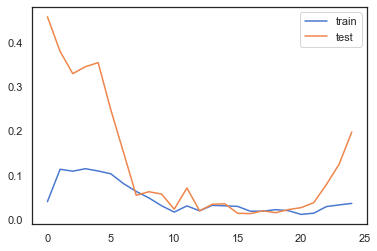

In [81]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

The blue line is the loss function that each epoch attempted to minimize.  The orange line is loss calculate from the validation set.  Since both losses trend downward and level out it appears this model trained well.

How accurate are the predictions on the test data?

In [82]:
# Run train test split before rerunning this cell
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_samples*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate Error
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(inv_y, inv_yhat)))
print("Mean squared error of the prediction: {}".format(mse(inv_y, inv_yhat)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100))
print('R-squared of the test set: {}'.format(r2_score(inv_y, inv_yhat)))

Mean absolute error of the prediction: 0.4641673266887665
Mean squared error of the prediction: 0.23496149480342865
Root mean squared error of the prediction: 0.2459591731758599
Mean absolute percentage error of the prediction: 67.31468439102173
R-squared of the test set: -3.050618526274464


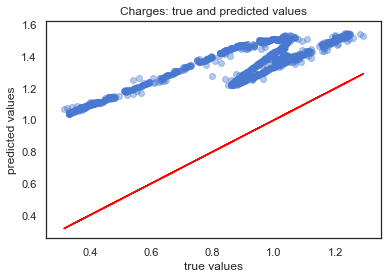

In [83]:
plot_pred(inv_y, inv_yhat)

All values are overpredicted.  In this case, the model may still be useful since using its predictions will still prevent overheating.  However, this high MAPE implies no predictions can be trusted.  

What about data from another trial?

In [84]:
df[feat][df['profile_id'] == 58].shape

(33381, 8)

In [85]:
data = df[temp][df['profile_id'] == 58]

dataset = data.copy()
#data after 30 minutes warm up
dataset = dataset[3600:]
values = dataset.values
# ensure all data is float
values = values.astype('float32')

scaled = scaler.transform(values)

# specify the number of lag samples
n_samples = 300 # half seconds memory
n_features = 6
# frame as supervised learning
reframed = series_to_supervised(scaled, n_samples, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_samples = int(values.shape[0]*0.8)
train = values[:n_train_samples, :]
test = values[n_train_samples:, :]
# split into input and outputs
n_obs = n_samples * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_samples, n_features))
test_X = test_X.reshape((test_X.shape[0], n_samples, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# Run train test split before rerunning this cell
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_samples*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


(29481, 1806)
(23584, 1800) 23584 (23584,)
(23584, 300, 6) (23584,) (5897, 300, 6) (5897,)


In [86]:
# calculate errors
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(inv_y, inv_yhat)))
print("Mean squared error of the prediction: {}".format(mse(inv_y, inv_yhat)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100))
print('R-squared of the test set: {}'.format(r2_score(inv_y, inv_yhat)))

Mean absolute error of the prediction: 0.3832176625728607
Mean squared error of the prediction: 0.15534019470214844
Root mean squared error of the prediction: 0.2459591731758599
Mean absolute percentage error of the prediction: 31.457501649856567
R-squared of the test set: -0.9962072103363766


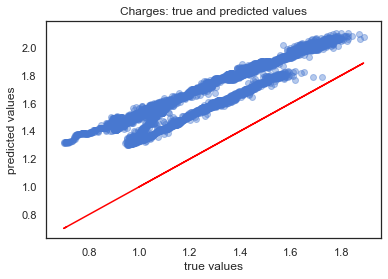

In [87]:
plot_pred(inv_y, inv_yhat)

Again, the model has more accurate predictions on another trial than on the holdout samples from the end of its own trial.  The R squared of 0.5 is encouraging, as is the lower MAPE at 0.15.  Overall, the predictions are still always above the true values, something that could be exploited if this is simply used to monitor heat thresholds.  

### Predicting Torque

For this last section we will develope a model for predicting the torque output of the motor instead of temperature.  We will only use the motors features and ignore temperature.  Having a model to predict torque by analyzing the other motor readings will be valuable for preventing dangerous shear forces that could damage the motor. 

#### Model Preparation

Split the data into train and test sets.

In [88]:
data = df[feat][df['profile_id'] == 57]
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_set, test_set = data.iloc[0:train_size].copy(), data.iloc[train_size:len(data)].copy()
print(train_set.shape, test_set.shape)

(11521, 8) (2881, 8)


We will use MinMaxScaler to scale all features.

In [89]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_set)
df_s = pd.DataFrame(scaled, columns=feat)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(df_s.drop('torque', axis=1), df_s['torque'], test_size = 0.2, shuffle=False)

X_train_cons = sm.add_constant(X_train)

X_test_cons = sm.add_constant(X_test)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 9216
The number of observations in test set is 2305


### Multiple Regression

Now we will create some multi dimensional regression models. We will start with Ordinary Least Squares with all the features included. We will then compare this to the various regularization techniques, Lasso (L1), Ridge(L2), and ElasticNet regression.

#### Ordinary Least Squares

In [91]:
lrm = linear_model.LinearRegression()
lrm.fit(X_train_cons, y_train) # .fit method estimates the coefficients using OLS. 
y_preds = lrm.predict(X_test_cons) # Get predictions.
results = sm.OLS(y_train, X_train_cons).fit() # Display Results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 torque   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.408e+07
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:15:43   Log-Likelihood:                 43296.
No. Observations:                9216   AIC:                        -8.658e+04
Df Residuals:                    9208   BIC:                        -8.652e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1573      0.004    -42.269      0.000      -0.165      -0.150
motor_speed     0.2348      0.002    139.967      0.000       0.232       0.238
i_q             0.9203      0.002    427.920      0.000       0.916       0.925
i_d             0.0708      0.001    130.617      0.000       0.070       0.072
u_q            -0.1492      0.001   -148.915      0.000      -0.151      -0.147
u_d             0.0094      0.002      4.482      0.000       0.005       0.013
p_q             0.0426      0.002     22.344      0.000       0.039       0.046
p_d             0.1713      0.001    123.736      0.000       0.169       0.174
==============================================================================
Omnibus:                     1014.274   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2354.218
Skew:                           0.662   Prob(JB):                         0.00
Kurtosis:                       5.093   Cond. No.                         394.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

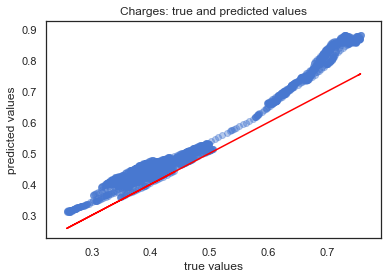

R-squared of the training set: 0.9999065664482183
-----Test set statistics-----
R-squared of the test set: 0.7392267065615974
Mean absolute error of the prediction: 0.06291224089753099
Mean squared error of the prediction: 0.0051995484715366795
Root mean squared error of the prediction: 0.07210789465472335
Mean absolute percentage error of the prediction: 12.72657700046336


In [92]:
y_preds = results.predict(X_test_cons)
plot_pred(y_test, y_preds)
print_stats(lrm, X_train_cons, y_train, X_test_cons, y_test, y_preds)

This higher training R squared compared to the test r squared implies this model is slightly overfit to training data.  However, a test R squared of .74 is still accurate and MAPE is low at 12.7%

#### Ridge Regression (L2)

When applying Ridge regression, we must specify a lambda value (alpha in python).  In this analysis, we will use RidgeCV to identify the best value.

Our cross valication set must not be randomly samples, we want earlier samples in the training set. Thus the KFold must have shuffle = False.

In [93]:
cv = KFold(5, shuffle=False)

In [94]:
ridgeCVregr = RidgeCV(alphas = np.logspace(start = -4, stop = 3, base = 2), cv = cv)
ridgeCVregr.fit(X_train, y_train)
y_preds_train = ridgeCVregr.predict(X_train)
y_preds_test = ridgeCVregr.predict(X_test)
ridgeCVregr.alpha_

0.2050838390019095

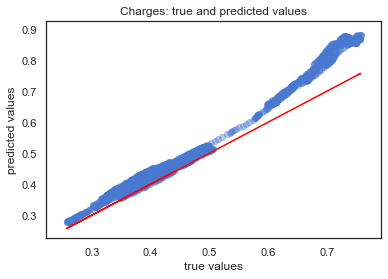

R-squared of the training set: 0.9998637930334638
-----Test set statistics-----
R-squared of the test set: 0.8050712841031598
Mean absolute error of the prediction: 0.0499176310594632
Mean squared error of the prediction: 0.0038866760220573225
Root mean squared error of the prediction: 0.062343211515427426
Mean absolute percentage error of the prediction: 9.367358446083289


In [95]:
plot_pred(y_test, y_preds_test)
print_stats(ridgeCVregr, X_train, y_train, X_test, y_test, y_preds_test)

Even better than OLS.

#### Lasso Regression (L1)

When applying Lasso regression, we must similarly specify a lambda value (alpha in python).  In this analysis, we will use LassoCV to identify the best value.

In [96]:
lassoCVregr = LassoCV(alphas = np.logspace(start = -11, stop = 2, base = 2), cv=cv)#, tol = 0.1)
lassoCVregr.fit(X_train, y_train)
y_preds_train = lassoCVregr.predict(X_train)
y_preds_test = lassoCVregr.predict(X_test)
lassoCVregr.alpha_

0.0014718401746203439

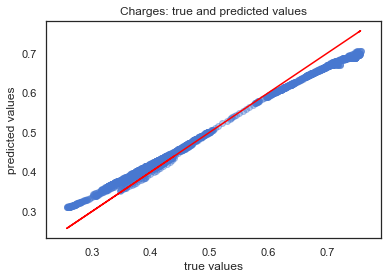

R-squared of the training set: 0.9969846507485203
-----Test set statistics-----
R-squared of the test set: 0.9680310995442213
Mean absolute error of the prediction: 0.021116047510175703
Mean squared error of the prediction: 0.0006374266525141912
Root mean squared error of the prediction: 0.025247309807466443
Mean absolute percentage error of the prediction: 4.628597318926408


In [97]:
plot_pred(y_test, y_preds_test)
print_stats(lassoCVregr, X_train, y_train, X_test, y_test, y_preds_test)

#### Elastinet Regression (L1 + L2)

ElasticNet combines the two previous regularization techniques.  For this analysis we willuse logspace to test l1 ratios and ElasticNetCV to choose alpha. 

In [98]:
elasticCVregr = ElasticNetCV(l1_ratio=np.logspace(start = -8, stop = 0, base = 2), cv=cv)  #tuned (0.1, 0.5, 0.05, 0.001, 0.005)
elasticCVregr.fit(X_train, y_train)
y_preds_train = elasticCVregr.predict(X_train)
y_preds_test = elasticCVregr.predict(X_test)
elasticCVregr.alpha_

0.00024839877864753164

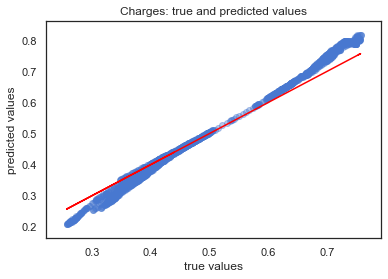

R-squared of the training set: 0.9995712228861624
-----Test set statistics-----
R-squared of the test set: 0.9594263671951159
Mean absolute error of the prediction: 0.021176854899640316
Mean squared error of the prediction: 0.0008089960733848876
Root mean squared error of the prediction: 0.028442856280354256
Mean absolute percentage error of the prediction: 4.38087239814453


In [99]:
plot_pred(y_test, y_preds_test)
print_stats(elasticCVregr, X_train, y_train, X_test, y_test, y_preds_test)

Performs about the same as lasso, best of the linear regression models.

#### Random Forest

For comparison to the regression techniques shown, we will implement a random forest model aswell. GridSearchCV will allow us to test a some combinations of parameters.  This has long runtime with two many parameter choices.  

In [100]:
rfr = ensemble.RandomForestRegressor() 
#parameters = { 'max_features':np.arange(5,(len(temp+feat)-1)),'n_estimators':[500,50],'min_samples_leaf':[10,50,100,200],'max_depth':np.arange(5, 15),'criterion':['mae', 'mse']}
parameters = { 'max_features':np.arange(5,(len(temp+feat)-1)),'n_estimators':[10],'min_samples_leaf':[50],'max_depth':[5],'criterion':['mae', 'mse']}
rfr_cv = GridSearchCV(rfr, parameters, cv = cv)
rfr_cv.fit(X_train, y_train)

C:\Users\CISteele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\CISteele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\CISteele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\CISteele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             ve

In [101]:
rfr_cv.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 7,
 'min_samples_leaf': 50,
 'n_estimators': 10}

In [102]:
y_preds_train = rfr_cv.predict(X_train)
y_preds_test = rfr_cv.predict(X_test)

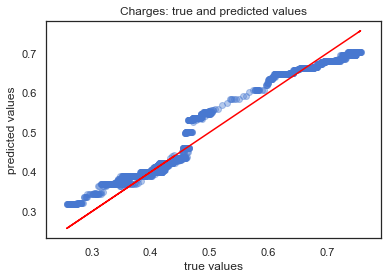

R-squared of the training set: 0.9992128728206474
-----Test set statistics-----
R-squared of the test set: 0.9598634631868926
Mean absolute error of the prediction: 0.02232256799261652
Mean squared error of the prediction: 0.0008002808335457483
Root mean squared error of the prediction: 0.028289235294467547
Mean absolute percentage error of the prediction: 4.916762087576451


In [103]:
plot_pred(y_test, y_preds_test)
print_stats(rfr_cv, X_train, y_train, X_test, y_test, y_preds_test)

Does not perform as well as Lasso or ElasticNet, but better than OLS or Ridge regression. 

It seems the best linear model is ElasticNet regression.

#### LSTM predicting Torque

Can we create an LSTM that predicts torque, or are the linear models already best?

In [104]:
data = df[feat][df['profile_id'] == 57]
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_set, test_set = data.iloc[0:train_size].copy(), data.iloc[train_size:len(data)].copy()
print(train_set.shape, test_set.shape)

(11521, 8) (2881, 8)


In [105]:
dataset = train_set.copy()
#data after 30 minutes warm up
dataset = dataset[3600:]
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [106]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [107]:
scaled.shape

(7921, 8)

The data has 8 features.  We will have a window of the last 300 samples (2 minutes 30 sec) in the recurrent neural network.  

In [108]:
# specify the number of lag samples
n_samples = 300 # half seconds memory
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_samples, 1)
print(reframed.shape)

(7621, 2408)


Create validation sets and reshape tensors.

In [109]:
# split into train and test sets
values = reframed.values
n_train_samples = int(values.shape[0]*0.8)
train = values[:n_train_samples, :]
test = values[n_train_samples:, :]
# split into input and outputs
n_obs = n_samples * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_samples, n_features))
test_X = test_X.reshape((test_X.shape[0], n_samples, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6096, 2400) 6096 (6096,)
(6096, 300, 8) (6096,) (1525, 300, 8) (1525,)


Create a Long Short Term Memory Recurrent Neural Network with 64 layers, then one dense sequential RNN. 

In [110]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# I have tuned LSTM(n, could add Dropout regularization

In [111]:
# takes 10 mins
time_start = time.time()

# fit network
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='min') #reduce patience or cap epochs to redcue runtime
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_split=0.2, callbacks=[es], verbose=2, shuffle=False)

print('Time elapsed: {} seconds'.format(time.time()-time_start))

Train on 4876 samples, validate on 1220 samples
Epoch 1/50
 - 13s - loss: 0.1199 - val_loss: 0.1471
Epoch 2/50
 - 14s - loss: 0.1578 - val_loss: 0.2348
Epoch 3/50
 - 13s - loss: 0.1133 - val_loss: 0.1147
Epoch 4/50
 - 15s - loss: 0.0801 - val_loss: 0.0254
Epoch 5/50
 - 13s - loss: 0.0347 - val_loss: 0.0743
Epoch 6/50
 - 13s - loss: 0.0694 - val_loss: 0.0834
Epoch 7/50
 - 12s - loss: 0.0393 - val_loss: 0.0323
Epoch 8/50
 - 12s - loss: 0.0357 - val_loss: 0.0680
Epoch 9/50
 - 12s - loss: 0.0540 - val_loss: 0.0293
Epoch 10/50
 - 12s - loss: 0.0381 - val_loss: 0.0697
Epoch 11/50
 - 12s - loss: 0.0399 - val_loss: 0.0275
Epoch 12/50
 - 12s - loss: 0.0240 - val_loss: 0.0103
Epoch 13/50
 - 13s - loss: 0.0336 - val_loss: 0.0165
Epoch 14/50
 - 13s - loss: 0.0419 - val_loss: 0.0189
Epoch 15/50
 - 14s - loss: 0.0365 - val_loss: 0.0111
Epoch 16/50
 - 12s - loss: 0.0301 - val_loss: 0.0122
Epoch 17/50
 - 13s - loss: 0.0277 - val_loss: 0.0122
Epoch 18/50
 - 13s - loss: 0.0269 - val_loss: 0.0345
Epoch 1

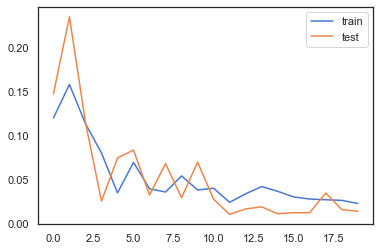

In [112]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

The blue line is the loss function that each epoch attempted to minimize.  The orange line is loss calculate from the validation set.  Since both losses trend downward and level out it appears this model trained well.

How accurate are the predictions on the test data?

In [113]:
# Run train test split before rerunning this cell
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_samples*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate Error
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(inv_y, inv_yhat)))
print("Mean squared error of the prediction: {}".format(mse(inv_y, inv_yhat)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100))
print('R-squared of the test set: {}'.format(r2_score(inv_y, inv_yhat)))

Mean absolute error of the prediction: 0.19791005551815033
Mean squared error of the prediction: 0.06856557726860046
Root mean squared error of the prediction: 0.028289235294467547
Mean absolute percentage error of the prediction: 46.69560194015503
R-squared of the test set: 0.8975483956089447


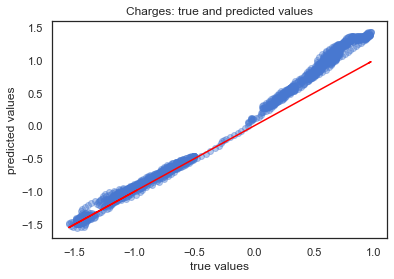

In [114]:
plot_pred(inv_y, inv_yhat)

What about data from another trial?

In [115]:
df[feat][df['profile_id'] == 58].shape

(33381, 8)

In [116]:
data = df[feat][df['profile_id'] == 58]

dataset = data.copy()
#data after 30 minutes warm up
dataset = dataset[3600:]
values = dataset.values
# ensure all data is float
values = values.astype('float32')

scaled = scaler.transform(values)

# specify the number of lag samples
n_samples = 300 # half seconds memory
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_samples, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_samples = int(values.shape[0]*0.8)
train = values[:n_train_samples, :]
test = values[n_train_samples:, :]
# split into input and outputs
n_obs = n_samples * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_samples, n_features))
test_X = test_X.reshape((test_X.shape[0], n_samples, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# Run train test split before rerunning this cell
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_samples*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate errors
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(inv_y, inv_yhat)))
print("Mean squared error of the prediction: {}".format(mse(inv_y, inv_yhat)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100))
print('R-squared of the test set: {}'.format(r2_score(inv_y, inv_yhat)))

(29481, 2408)
(23584, 2400) 23584 (23584,)
(23584, 300, 8) (23584,) (5897, 300, 8) (5897,)
Mean absolute error of the prediction: 0.165343776345253
Mean squared error of the prediction: 0.052911899983882904
Root mean squared error of the prediction: 0.028289235294467547
Mean absolute percentage error of the prediction: 196.89478874206543
R-squared of the test set: 0.927909141243467


In [117]:
# calculate errors
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(inv_y, inv_yhat)))
print("Mean squared error of the prediction: {}".format(mse(inv_y, inv_yhat)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100))
print('R-squared of the test set: {}'.format(r2_score(inv_y, inv_yhat)))

Mean absolute error of the prediction: 0.165343776345253
Mean squared error of the prediction: 0.052911899983882904
Root mean squared error of the prediction: 0.028289235294467547
Mean absolute percentage error of the prediction: 196.89478874206543
R-squared of the test set: 0.927909141243467


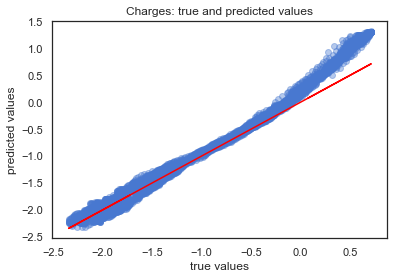

In [118]:
plot_pred(inv_y, inv_yhat)

The LSTM on torque performed fairly well, with a test R squared of 0.84 on a separate trial.  However, the linear models, especially ElasticNet, were more accurate for predicting torque than this LSTM.  Perhaps with better tuning and a redesign of the layers we could increase the accuracy.  

### Conclusion

The models above are for monitoring and forecasting rotor temperature and torque in electric vehicle motors.  These models are trained on time series data that represents behavior similar to highway driving.  Each Recurrent Neural Netword consist of a 128 node LSTM with a memory window of 300 samples (2 min 30 sec).  If the model can be incorporated into the electric motors monitoring software, it could be fed data from the past 150 seconds to forecast rotor temp and torque.  These forecasts can be used to prevent the motor from exceeding operational thresholds.  High rotor temp would result in overheating and could damage internal components.  In particular, overheating magnets will reduce their magnetism.  High torque will reduce the lifespan on engineered components by inducing shear forces and may cause damage to the motor or drivetrain.  